In [21]:
import os
import os.path
import sys
import importlib
import yaml
from copy import deepcopy
import subprocess

from time import time
from datetime import datetime

import numpy as np
import pandas as pd
import math

import scipy
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from matplotlib import rcParams
import matplotlib as mpl
from matplotlib  import cm
from PIL import Image
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from matplotlib.cbook import get_sample_data

import multiprocessing

from sklearn.metrics import mean_squared_error

import copy
preFactor = 2*kbt 
import importlib
#import calculateFES
#importlib.reload(calculateFES)
from numpy import ones,copy,cos,tan,pi,linspace

from scipy.interpolate import RegularGridInterpolator,LinearNDInterpolator, RectBivariateSpline,interpn, griddata
import warnings
warnings.filterwarnings("ignore")

In [22]:
frac = 1.5
width = [0.53*0.5*frac,0.65*0.5*frac,0.83*0.5*frac]
height = 0.78*0.5*frac

font = {'weight' : 'normal',
        'size'   : 22} 
plt.rc('font', **font)

from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

#### Free energy surface 1 block, dimr,dimz=200

In [23]:
############## PRODUCTION RUNNNNNN

C0 = 1/(1661*1e-3)
kb = 8.31446261815324*0.001 #kJ/molK
temperature = 300
kbt = kb*temperature  #kJ/mol
probe= ['acd','bcd','gcd']
analyte = ['TCAA','pfos']
#choose number of blocks
preFactor = 2*kbt #kJ/mol for entropy correction
blocks = 1 #3
cutoff1 = np.sqrt(3.5)
cutoff2 = 2
sfes_mast = []
smast = []
for dimr in [200]:
    for cutoff in [1]:
        dimz = dimr
        pmf_probe_analyte_zero_ref_boundary = {} # collect pmfs
        pmf_probe_analyte_zero_ref_global_minima = {} # collect pmfs

        #for ii in probe:
        for kk in analyte:
            for ii in probe:
                sfes = []
                sval = []
                pmf_probe_analyte_zero_ref_global_minima[ii+'_'+kk] = {}
                pmf_probe_analyte_zero_ref_boundary[ii+'_'+kk]  = {}

                #create holders
                fep = []
                avgFE,sdFE = [],[]
                avgkb,sdkb = [],[]
                #load data 
                colvarFile = '/project2/andrewferguson/maxtopel/PFAS_TACC/system-cd/reweights/'+kk+'-'+ii+"/COLVAR_reweight" #simDir + systemDir + colvarFileName
                #print(colvarFile)
                colvarData = pd.read_csv(colvarFile, comment="#", 
                                         delim_whitespace=True,names=["time", "angle", "r", 
                                                                      "baxis","mag", "pr", "pz", "bias"],
                                         skip_blank_lines=True)

                # discard initial few frames [frames where free energy is still being mapped]
                # subsample and randomize
                if kk=='pfos': #probe=='acd' or probe=='gcd' and analyte=='pfos':
                    s = 50000
                    d = -1 #500001
                    colvarD = colvarData[s:d].sample(frac = 1)
                else:
                    s = 100000
                    d = -1 #1000000
                    colvarD = colvarData[s:d:2].sample(frac = 1)        
                jmp = len(colvarD)//blocks

                print(ii,kk, len(colvarD), blocks, jmp)
                #\print(colvarD)
                for jj in range(blocks):
                    colvarData_init = colvarD[jmp*jj:jmp*(jj+1)] 
                    print(f'Before filter: {colvarData_init.shape}')


                    #colvarData = colvarData_init[(colvarData_init['r']**2 + colvarData_init['baxis']**2 < 3.5)]

                    #colvarData_2 = colvarData_init[(colvarData_init['r'] < cutoff1)]
                    #colvarData_3 = colvarData_2[(colvarData_2['baxis'] < cutoff1)]
                    #colvarData = colvarData_3[(colvarData_3['baxis'] >= -cutoff1)]
                    
                    #colvarData = colvarData_init

                    print(f'After filter (<3. spherical cut): {colvarData.shape}')

                    ############################################################################################################
                    #make a 2D heat map
                    bias = colvarData_init['bias'] 
                    r = colvarData_init['r']
                    z = colvarData_init['baxis']
                    print(len(bias), ' is bias length')
                    # calculate weights of each frame in colvarData - CHECK THIS APPROACH (SUMMING THE BIASES)
                    weights = np.exp((bias) /kbt)        
                    xedges = np.linspace(0,cutoff2,dimr)
                    yedges = np.linspace(-cutoff2,cutoff2,dimz)
                    dr,dz = abs(xedges[0]-xedges[1]),abs(yedges[0]-yedges[1])
                    # get unbiased probabilities
                    fe, xedges,yedges = np.histogram2d(r,z,range=[[0,cutoff2],[-cutoff2,cutoff2]],
                                                       bins=(xedges,yedges),
                                                       weights=weights,density=True)


                    # get unbiased probabilities -- 1 D along r, z
                    fe_r, xedges_r = np.histogram(r, range=[0,cutoff1], bins=xedges, weights=weights,density=True)
                    fe_z, xedges_z = np.histogram(z, range=[-cutoff1,cutoff1], bins=yedges, weights=weights,density=True)
                    fe_r = fe_r.T
                    fe_z = fe_z.T
                    fe_r = -kbt*np.log(fe_r)
                    fe_z = -kbt*np.log(fe_z)
                    
                    fe = fe.T
                    feDf = -kbt*np.log(fe) # Compute free energy
######## correction
                    #correction
                    for ki in range(xedges.shape[0]-1):
                        for kj in range(yedges.shape[0]-1):
        #                     if xedges[ki]**2 + np.abs(yedges[kj])**2 > 1.25: # 2.0:
                   
                            if np.isnan(feDf[kj,ki]) or np.isinf(feDf[kj,ki]):
                                continue
    
                            s = np.sqrt(xedges[ki]**2+yedges[kj]**2)
                            feDf[kj,ki] += preFactor*np.log(s)
####################################



                   # print(feDf)

                    feDf_zero_ref_global_minima = feDf - feDf.min() # UNCOMMENT THIS FOR SETTING GLOBAL FREE ENERGY MINIMA AS ZERO

                    _block_data_global_minima = {'fe': feDf_zero_ref_global_minima, 
                                                 'xedges': xedges, 'yedges': yedges}

                    pmf_probe_analyte_zero_ref_global_minima[ii+'_'+kk]['block'+str(jj)] = _block_data_global_minima

                    # Find values of free energy on the boundary of the surface
                    avg_fe_beyond_cutoff=[]
                    for ki in range(xedges.shape[0]-1):
                        for kj in range(yedges.shape[0]-1):
        #                     if xedges[ki]**2 + np.abs(yedges[kj])**2 > 1.25: # 2.0:
                   
                            if np.isnan(feDf[kj,ki]) or np.isinf(feDf[kj,ki]):
                                continue
                            
                            #cutoffs
                            s = np.sqrt(xedges[ki]**2+yedges[kj]**2)
                            sfes.append(feDf[kj,ki])
                            sval.append(s)
                            if s > 1.2 and s < np.sqrt(3.5): #xedges[ki] > cutoff or yedges[kj] < -cutoff or yedges[kj] > cutoff and xedges[ki] < cutoff1 and yedges[kj] < cutoff1 and yedges[kj] > cutoff1:
                                avg_fe_beyond_cutoff.append(feDf[kj,ki])

                           

                    avg_fe_beyond_cutoff = np.array(avg_fe_beyond_cutoff)

                    print(f'avg:{avg_fe_beyond_cutoff.mean()}, sd:{np.std(avg_fe_beyond_cutoff)},max:{avg_fe_beyond_cutoff.max()}, min:{avg_fe_beyond_cutoff.min()}')

                    #feDf_zero_ref_boundary = feDf - feDf.max() #collect_fe_k_max # UNCOMMENT THIS FOR SETTING BOUNDARY FREE ENERGY TO ZERO
                    feDf_zero_ref_boundary = feDf - avg_fe_beyond_cutoff.mean() #collect_fe_k_max # UNCOMMENT THIS FOR SETTING BOUNDARY FREE ENERGY TO ZERO
                    fe_r = fe_r - avg_fe_beyond_cutoff.mean()
                    fe_z = fe_z - avg_fe_beyond_cutoff.mean()

                    print(xedges.min(), xedges.max(), yedges.min(), yedges.max())

                    _block_data_boundary = {'fe': feDf_zero_ref_boundary,
                                            'xedges': xedges,
                                            'yedges': yedges,
                                            'fe_r': fe_r,
                                             'xedges_r':xedges_r,
                                            'fe_z': fe_z,
                                             'xedges_z':xedges_z}
                                            #'fe_points_on_boundary': fe_points_on_boundary}

                    pmf_probe_analyte_zero_ref_boundary[ii+'_'+kk]['block'+str(jj)] = _block_data_boundary
                    sfes_mast.append(sfes)
                    smast.append(sval)
                    print(ii, kk, jj)
                    print(dimr,dimz,cutoff)


acd TCAA 450000 1 450000
Before filter: (450000, 8)
After filter (<3. spherical cut): (1000001, 8)
450000  is bias length
avg:14.506501954082708, sd:2.2774870444981397,max:60.26958853986492, min:9.187670594291891
0.0 2.0 -2.0 2.0
acd TCAA 0
200 200 1
bcd TCAA 450000 1 450000
Before filter: (450000, 8)
After filter (<3. spherical cut): (1000001, 8)
450000  is bias length
avg:9.096386065319942, sd:1.550859597342016,max:14.322214803853674, min:5.2905869111700765
0.0 2.0 -2.0 2.0
bcd TCAA 0
200 200 1
gcd TCAA 450000 1 450000
Before filter: (450000, 8)
After filter (<3. spherical cut): (1000001, 8)
450000  is bias length
avg:12.812488166485714, sd:2.27528209951338,max:57.54198893373596, min:6.15863700338176
0.0 2.0 -2.0 2.0
gcd TCAA 0
200 200 1
acd pfos 450000 1 450000
Before filter: (450000, 8)
After filter (<3. spherical cut): (500001, 8)
450000  is bias length
avg:22.363940549423823, sd:2.280463657679441,max:40.07699581840871, min:15.189831881199508
0.0 2.0 -2.0 2.0
acd pfos 0
200 200 1


#### Convert to feDf as a function of s, histogram

In [24]:
#colors=['blue','green','red']
mt = []
iii = 0
for kk in analyte:
    mtot = []
    for ii in probe:
        bins = np.linspace(0, 2 + 1e-12, 51) # 10 bins, so 11 bin boundaries
        c = np.digitize(smast[iii], bins)
        c = list(c)
        indx = []
        lst =  list(enumerate(c))
        for ijk in range(len(bins)):
            indices = []
            for val in range(len(lst)):
                if lst[val][1]==ijk:
                    indices.append(lst[val][0])
            indx.append(indices)
        mval,stval = [],[]
        sfesp = np.array(sfes_mast[iii])
        for ijk in range(len(indx)):
            mval.append(np.mean(sfesp[indx[ijk]]))
           # if ijk>49 and ijk<95:
           # corrval.append())
        #    stval.append(np.std(sfesp[indx[ijk]]))
        mtot.append(mval)
        iii+=1
    mt.append(mtot)

        #plt.plot(bins[:-1], fe_r, color=colors[i], label=kk.upper())


    #plt.show()
   # plt.savefig('s_fedf_%s.png' %(ii.upper()),dpi=300)
   # plt.close()



### plot FES as a function of s

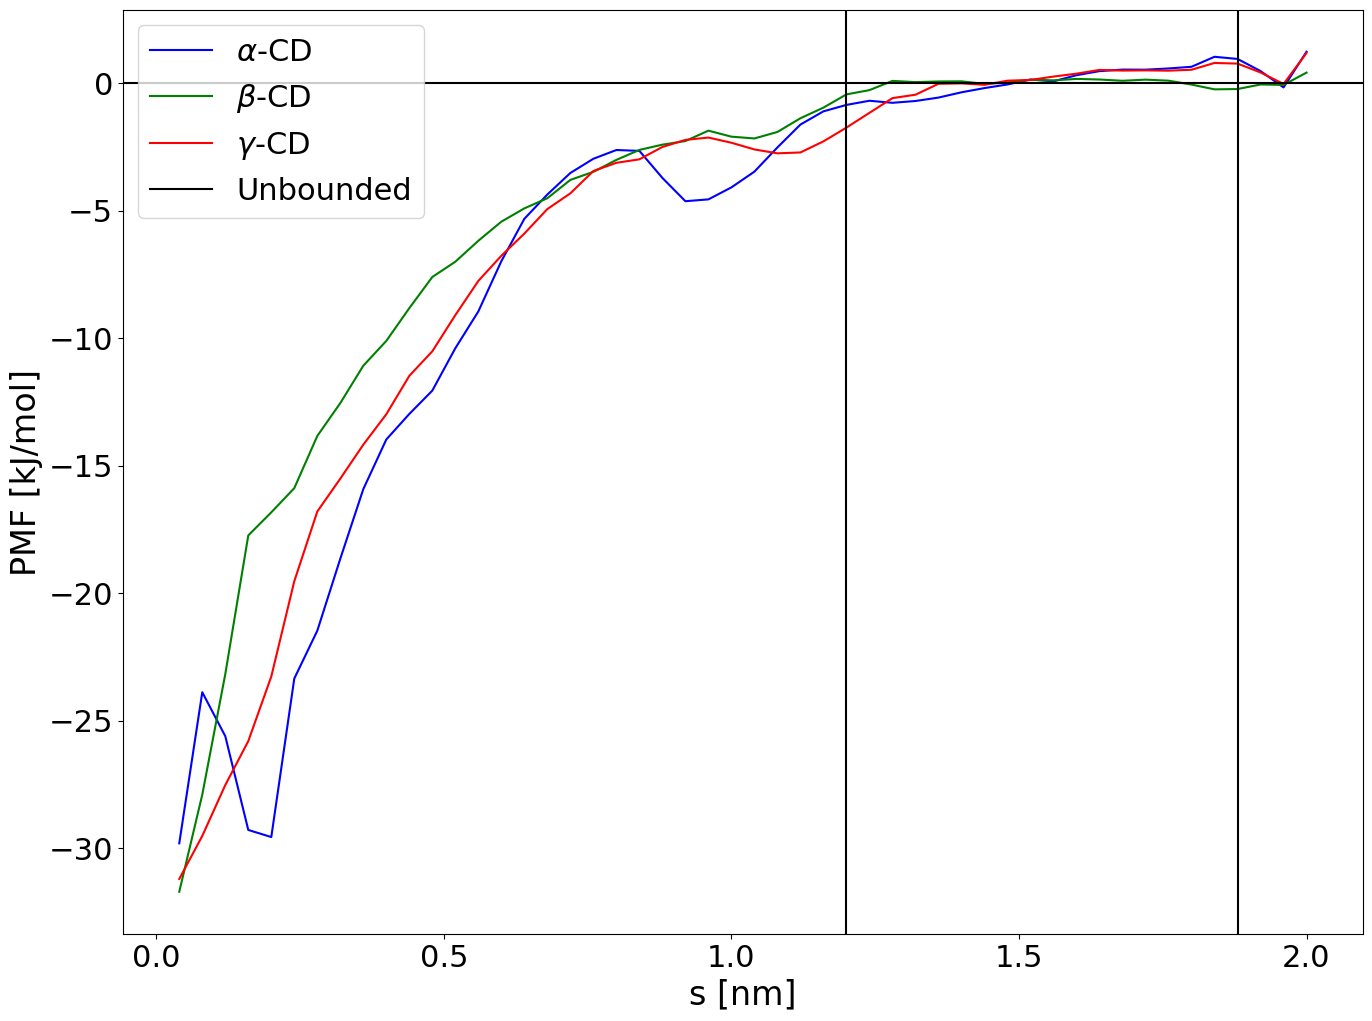

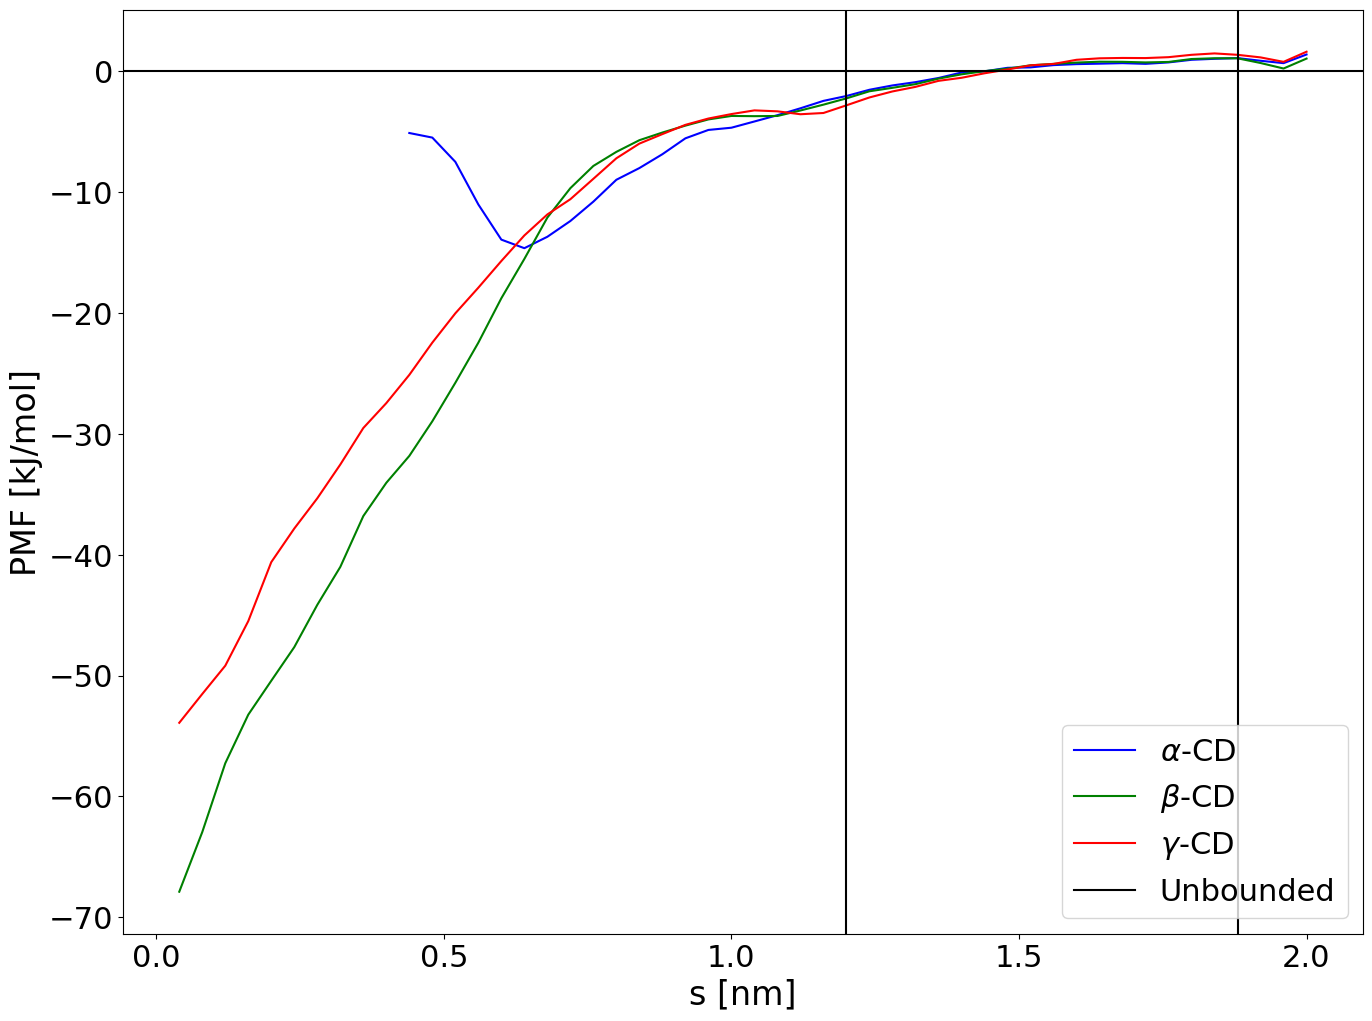

In [25]:
colors=['blue','green','red']
iii = 0
for kk in analyte:
    plts = mt[iii]
    plt.figure(figsize=(16, 12))
    plt.xlabel('s [nm]',fontsize=24)
    plt.ylabel('PMF [kJ/mol]',fontsize=24)
    jjj = 0
    plt.xticks(np.linspace(0,50,5),np.linspace(0,2,5))
    for ii in ['$\\alpha$-CD','$\\beta$-CD','$\\gamma$-CD']:
        pltp = np.subtract(plts[jjj],np.mean(plts[jjj][30:47]))
        plt.plot(pltp, color=colors[jjj], label=ii)
        jjj+=1
    jjj = 0
    #plt.legend()
    plt.axvline(x=30,color='k',label='Unbounded')
    plt.axvline(x=47,color='k')    
    plt.axhline(y=0,color='k')
    plt.legend()
    plt.show()
    plt.savefig('s_fedf_%s.png' %(ii.upper()),dpi=300)
    plt.close()
    iii +=1



#### plot as a function of r,z

TCAA acd
TCAA bcd
TCAA gcd
pfos acd
pfos bcd
pfos gcd
TCAA acd
TCAA bcd
TCAA gcd
pfos acd
pfos bcd
pfos gcd


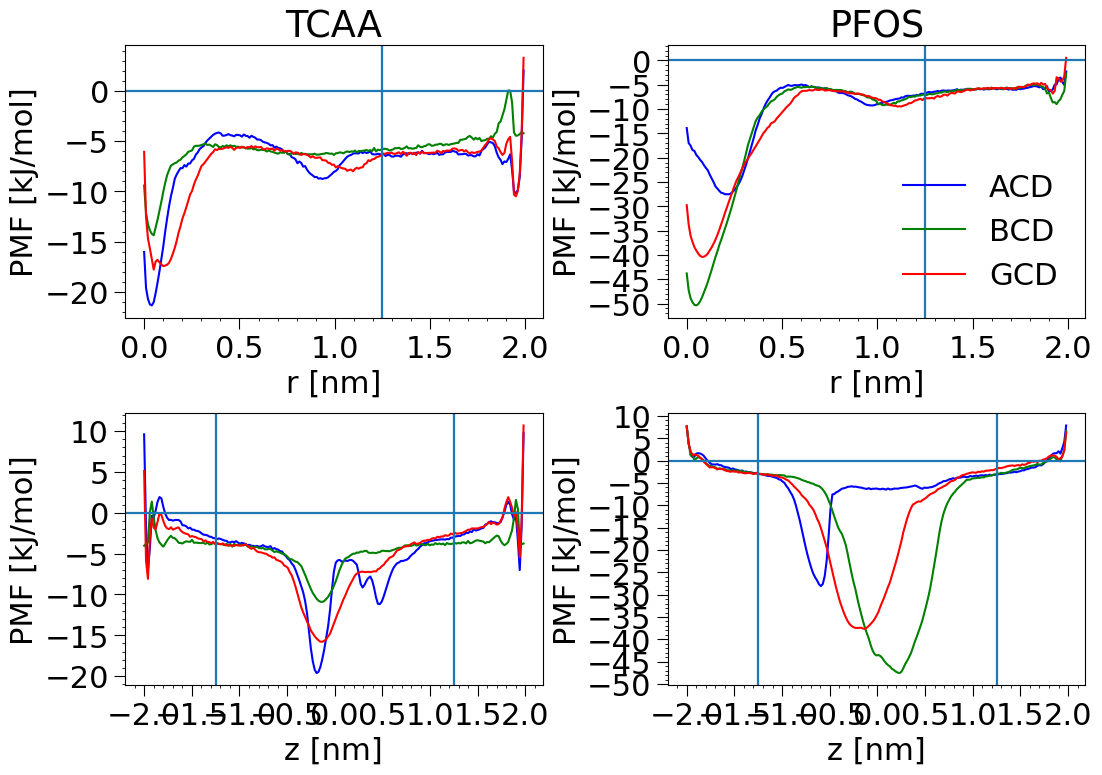

In [26]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

# Set the figure size
fig = plt.figure(figsize=(12, 8))

# Adjust spacing
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.3, hspace=0.35)

# Create a 3x3 grid
grid = GridSpec(2, 2)

probe= ['acd','bcd','gcd']
analyte = ['TCAA','pfos']

selected_block = 0 # entire data is used.


colors=['blue','green','red']
for k, kk in enumerate(analyte):
    
    ax = plt.subplot(grid[0,k])
    ax.set_title(kk.upper())
    
    for i, ii in enumerate(probe):
        # Create subplots
        
        
        print(kk,ii)
        #selected_fe = pmf_probe_analyte_zero_ref_global_minima
        selected_fe = pmf_probe_analyte_zero_ref_boundary
        
        
        fe_r = selected_fe[ii+'_'+kk]['block'+str(selected_block)]['fe_r']
        xedges_r = selected_fe[ii+'_'+kk]['block'+str(selected_block)]['xedges_r']
        
        ax.plot(xedges_r[:-1], fe_r, color=colors[i], label=ii.upper())
        
        ax.set_xlabel('r [nm]')
        ax.set_ylabel('PMF [kJ/mol]')
        
        ax.xaxis.set_major_locator(MultipleLocator(0.5))
        ax.yaxis.set_major_locator(MultipleLocator(5))
        ax.xaxis.set_minor_locator(AutoMinorLocator(n=5))
        ax.yaxis.set_minor_locator(AutoMinorLocator(n=5))
        ax.tick_params(which='major', length=8)
        ax.tick_params(which='minor', length=2)
        
        ax.axvline(x=1.25)
        ax.axhline(y=0)
        
        
ax.legend(frameon=False)
        
colors=['blue','green','red']
for k, kk in enumerate(analyte):
    
    ax = plt.subplot(grid[1,k])
    
    for i, ii in enumerate(probe):
        # Create subplots
        
        
        print(kk,ii)
        #selected_fe = pmf_probe_analyte_zero_ref_global_minima
        selected_fe = pmf_probe_analyte_zero_ref_boundary
        
        
        fe_z = selected_fe[ii+'_'+kk]['block'+str(selected_block)]['fe_z']
        xedges_z = selected_fe[ii+'_'+kk]['block'+str(selected_block)]['xedges_z']
        
        ax.plot(xedges_z[:-1], fe_z, color=colors[i])
        
        ax.set_xlabel('z [nm]')
        ax.set_ylabel('PMF [kJ/mol]')
                  

#         ax.set_xlabel('r [nm]')
#         ax.set_ylabel('z [nm]')
#         ax.set_title(kk.upper()+':'+ii.upper())
        
        ax.xaxis.set_major_locator(MultipleLocator(0.5))
        ax.yaxis.set_major_locator(MultipleLocator(5))
        ax.xaxis.set_minor_locator(AutoMinorLocator(n=5))
        ax.yaxis.set_minor_locator(AutoMinorLocator(n=5))
        ax.tick_params(which='major', length=8)
        ax.tick_params(which='minor', length=2)
        
        ax.axvline(x=1.25)
        ax.axvline(x=-1.25)
        
        ax.axhline(y=0)
        
        
        

        

#### plot the surfaces using the saved dictionary, horizontal, vertical and render for cbar

0.0 2.0 -2.0 2.0
0.0 2.0 -2.0 2.0
0.0 2.0 -2.0 2.0
0.0 2.0 -2.0 2.0
0.0 2.0 -2.0 2.0
0.0 2.0 -2.0 2.0


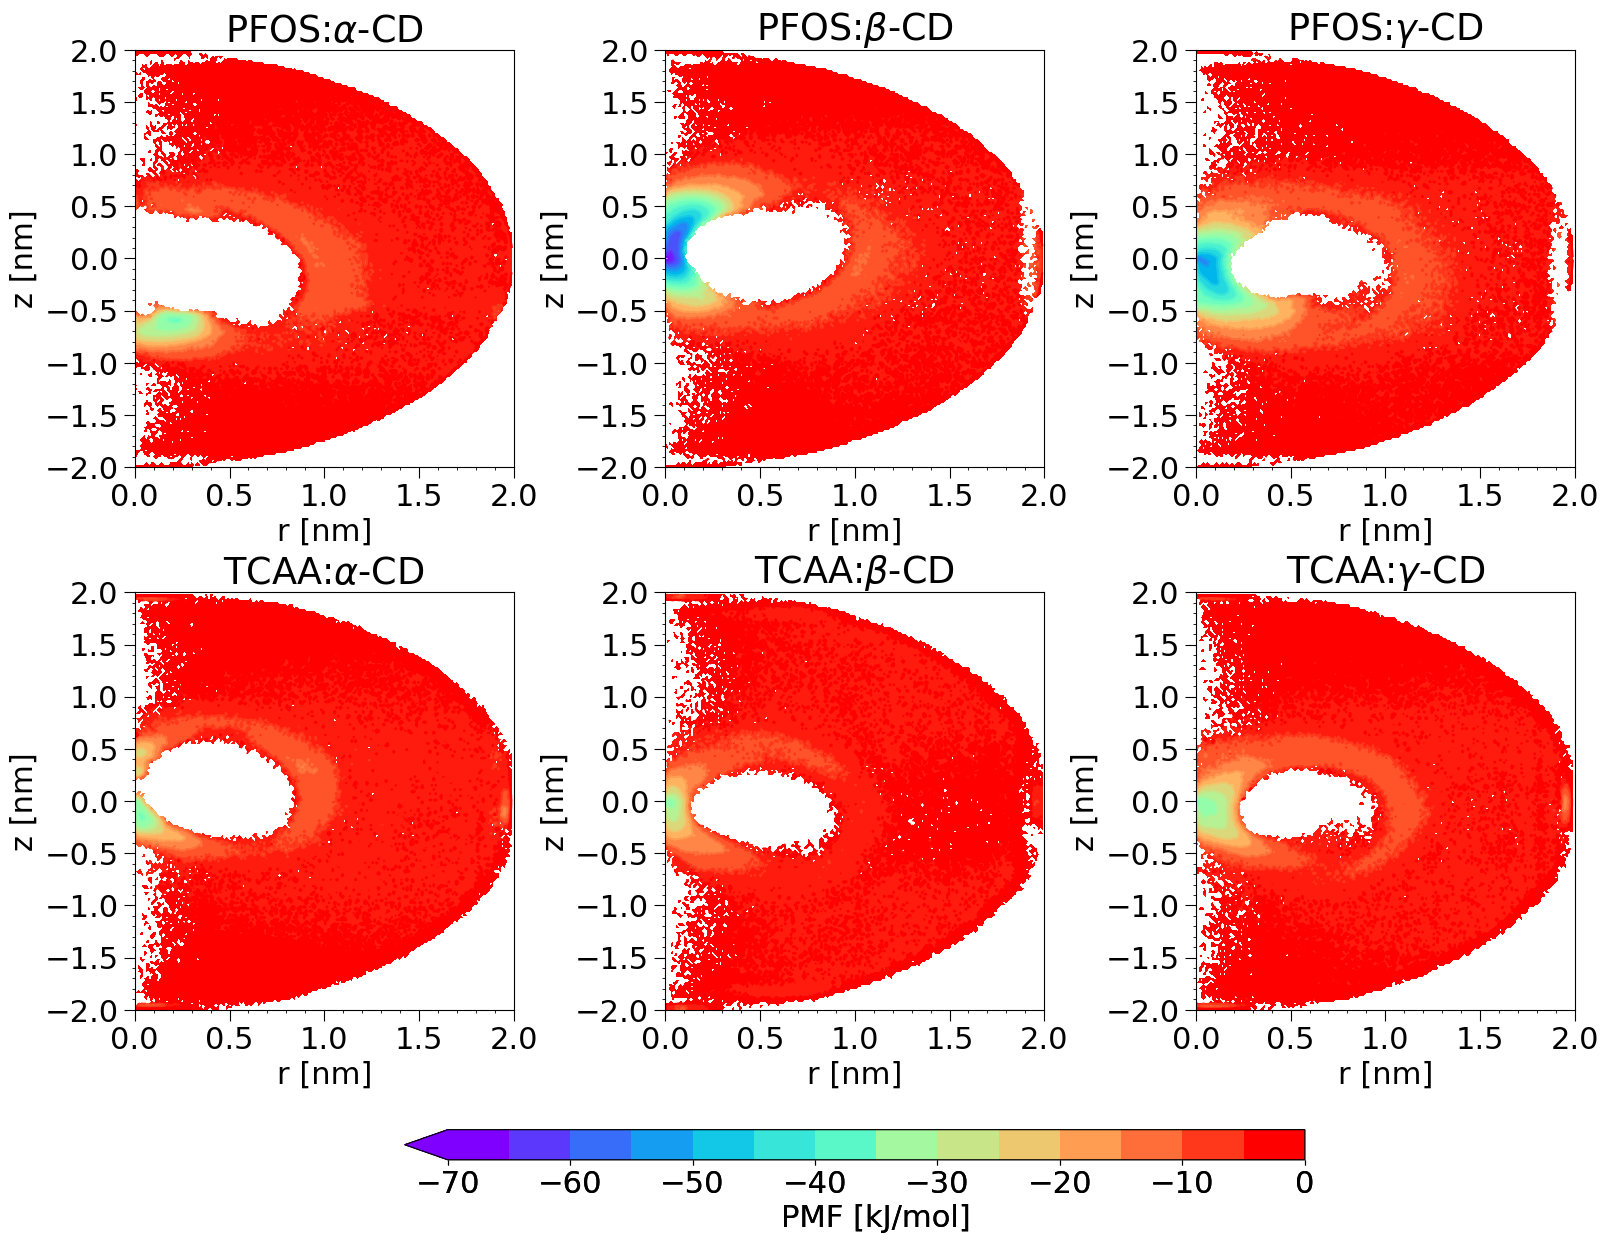

In [10]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

# Set the figure size
fig = plt.figure(figsize=(18, 12))

# Adjust spacing
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.3)

# Create a 3x3 grid
grid = GridSpec(2, 3)

probe= ['acd','bcd','gcd']
analyte = ['pfos','TCAA']
lbl = ['$\\alpha$-CD','$\\beta$-CD','$\\gamma$-CD']
selected_block = 0 # entire data is used.

for k, kk in enumerate(analyte):
    for i, ii in enumerate(probe):
        
        # Create subplots
        ax = plt.subplot(grid[k, i])
        
        #selected_fe = pmf_probe_analyte_zero_ref_global_minima
        selected_fe = pmf_probe_analyte_zero_ref_boundary
       
        fe = selected_fe[ii+'_'+kk]['block'+str(selected_block)]['fe']
        #fe = np.flip(fe,axis=0)
        xedges = selected_fe[ii+'_'+kk]['block'+str(selected_block)]['xedges']
        yedges = selected_fe[ii+'_'+kk]['block'+str(selected_block)]['yedges']
        
        x, y = np.meshgrid(xedges, yedges)
        #contour_levels = np.linspace(fe.min(), 0, 15) 
        contour_levels = np.linspace(-70, 0, 15) 
        
    
        ax.contour(x[:-1, :-1], y[:-1, :-1], fe, cmap='rainbow', levels=contour_levels,vmin=-70,vmax=0)
        contour_plot = ax.contourf(x[:-1, :-1], y[:-1, :-1], fe, cmap='rainbow', levels=contour_levels, extend='max',vmin=-70,vmax=0)
        
        #print(fe.max(), np.isinf(fe).any(), np.isnan(fe).any())
        
        from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
        from matplotlib.cm import get_cmap
        from matplotlib.colors import ListedColormap
        if i==2: #ldns
            cbar_ax = fig.add_axes([0.25, -0.025, 0.5, 0.025]) #x-location, y-location, width, height of bar
            tick_bounds = [-70,-60,-50,-40,-30,-20,-10,0]
            bounds = [-70,-65,-60,-55,-50,-45,-40,-35,-30,-25,-20,-15,-10,-5,0]
            ncolors = get_cmap('rainbow')(np.linspace(0, 1, len(bounds)))
            cmap = ListedColormap(ncolors)
            norm = mpl.colors.BoundaryNorm(bounds, len(bounds))
            cb = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap,
                                           boundaries=bounds, 
                                           norm=mpl.colors.Normalize(vmin=bounds[0], vmax=bounds[-1]),
                                           extend='min',
                                           spacing='uniform', orientation='horizontal')
            #cb.ax.set_xticklabels(bounds)
            cb.ax.set_xticks(tick_bounds)
            cb.set_label('PMF [kJ/mol]')
            

        fe_beyond_cutoff = []
        print(xedges.min(), xedges.max(), yedges.min(), yedges.max())
        for ki in range(xedges.shape[0]-1):
            for kj in range(yedges.shape[0]-1):
                
                
                if np.isnan(fe[kj,ki]) or np.isinf(fe[kj,ki]):
                    continue

                if .99 <= xedges[ki] <= 1.01 and -0.94  <= yedges[kj] <= 0.95:
                    fe_beyond_cutoff.append(fe[kj,ki])

        ax.set_xlabel('r [nm]')
        ax.set_ylabel('z [nm]')
        ax.set_title(kk.upper()+':'+lbl[i])
       
        ax.xaxis.set_major_locator(MultipleLocator(0.5))
        ax.set_xlim(0.0,2.0001)
        ax.set_ylim(-2,2.0001)
        ax.yaxis.set_major_locator(MultipleLocator(0.5))
        ax.xaxis.set_minor_locator(AutoMinorLocator(n=5))
        ax.yaxis.set_minor_locator(AutoMinorLocator(n=5))
        ax.tick_params(which='major', length=8)
        ax.tick_params(which='minor', length=2)
        plt.savefig('M1.png',dpi=300)
        

        

0.0 2.0 -2.0 2.0
0.0 2.0 -2.0 2.0
0.0 2.0 -2.0 2.0
0.0 2.0 -2.0 2.0
0.0 2.0 -2.0 2.0
0.0 2.0 -2.0 2.0


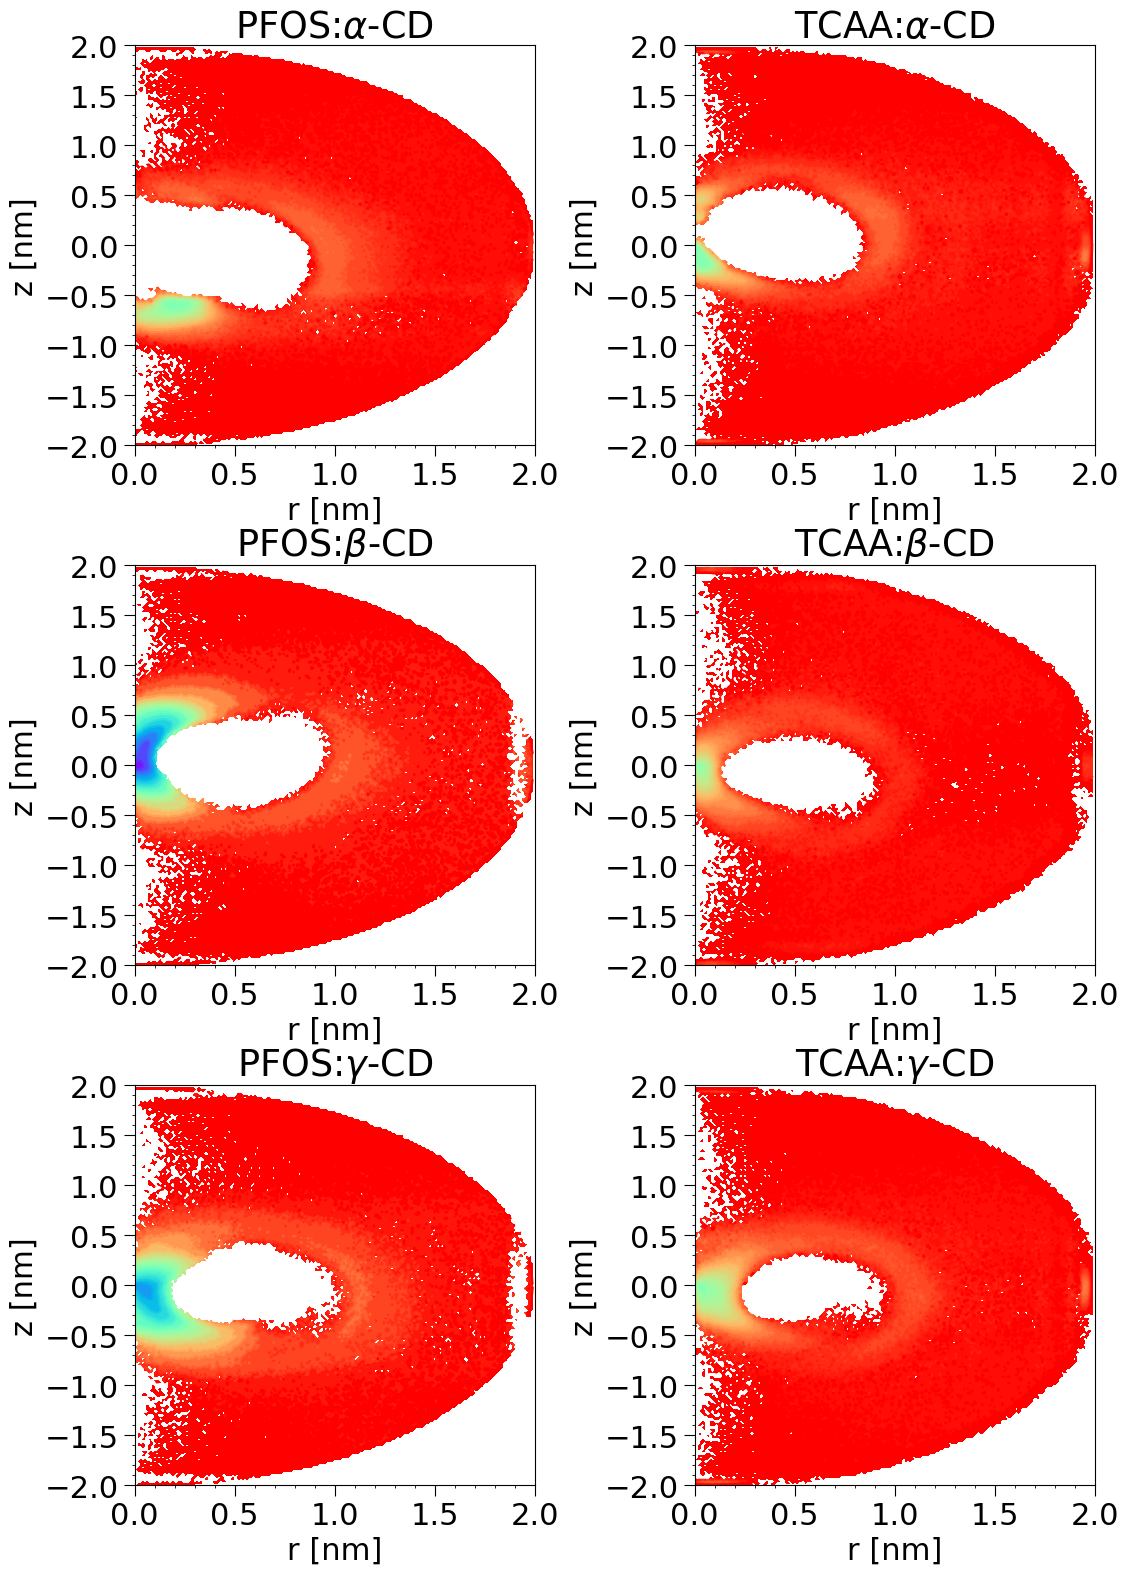

In [27]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

# Set the figure size
fig = plt.figure(figsize=(12, 18))

# Adjust spacing
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.3)

# Create a 3x3 grid
grid = GridSpec(3, 2)

probe= ['acd','bcd','gcd']
analyte = ['pfos','TCAA']
lbl = ['$\\alpha$-CD','$\\beta$-CD','$\\gamma$-CD']
selected_block = 0 # entire data is used.

for k, kk in enumerate(analyte):
    for i, ii in enumerate(probe):
       
        # Create subplots
        ax = plt.subplot(grid[i, k])
        
        #selected_fe = pmf_probe_analyte_zero_ref_global_minima
        selected_fe = pmf_probe_analyte_zero_ref_boundary
       
        fe = selected_fe[ii+'_'+kk]['block'+str(selected_block)]['fe']
        #fe = np.flip(fe,axis=0)
        xedges = selected_fe[ii+'_'+kk]['block'+str(selected_block)]['xedges']
        yedges = selected_fe[ii+'_'+kk]['block'+str(selected_block)]['yedges']
        
        x, y = np.meshgrid(xedges, yedges)
        contour_levels = np.linspace(fe.min(), 0, 15) 
    
        ax.contour(x[:-1, :-1], y[:-1, :-1], fe, cmap='rainbow', levels=contour_levels,vmin=-70,vmax=0)
        contour_plot = ax.contourf(x[:-1, :-1], y[:-1, :-1], fe, cmap='rainbow', levels=contour_levels, extend='max',vmin=-70,vmax=0)
        
        #print(fe.max(), np.isinf(fe).any(), np.isnan(fe).any())
        
        #if i==2:ldns
        #plt.colorbar(contour_plot, label='G [kJ/mol]',location='bottom',ticks=[0,-10,-20,-30,-40,-50])
        

        fe_beyond_cutoff = []
        print(xedges.min(), xedges.max(), yedges.min(), yedges.max())
        for ki in range(xedges.shape[0]-1):
            for kj in range(yedges.shape[0]-1):
                
                
                if np.isnan(fe[kj,ki]) or np.isinf(fe[kj,ki]):
                    continue

                if .99 <= xedges[ki] <= 1.01 and -0.94  <= yedges[kj] <= 0.95:
                    fe_beyond_cutoff.append(fe[kj,ki])

        ax.set_xlabel('r [nm]')
        ax.set_ylabel('z [nm]')
        ax.set_title(kk.upper()+':'+lbl[i])
       
        ax.xaxis.set_major_locator(MultipleLocator(0.5))
        ax.set_xlim(0.0,2.0001)
        ax.set_ylim(-2,2.0001)
        ax.yaxis.set_major_locator(MultipleLocator(0.5))
        ax.xaxis.set_minor_locator(AutoMinorLocator(n=5))
        ax.yaxis.set_minor_locator(AutoMinorLocator(n=5))
        ax.tick_params(which='major', length=8)
        ax.tick_params(which='minor', length=2)
        plt.savefig('M1_vert.png',dpi=300)
        

        

0.0 2.0 -2.0 2.0
0.0 2.0 -2.0 2.0


0.0 2.0 -2.0 2.0
0.0 2.0 -2.0 2.0
0.0 2.0 -2.0 2.0
0.0 2.0 -2.0 2.0


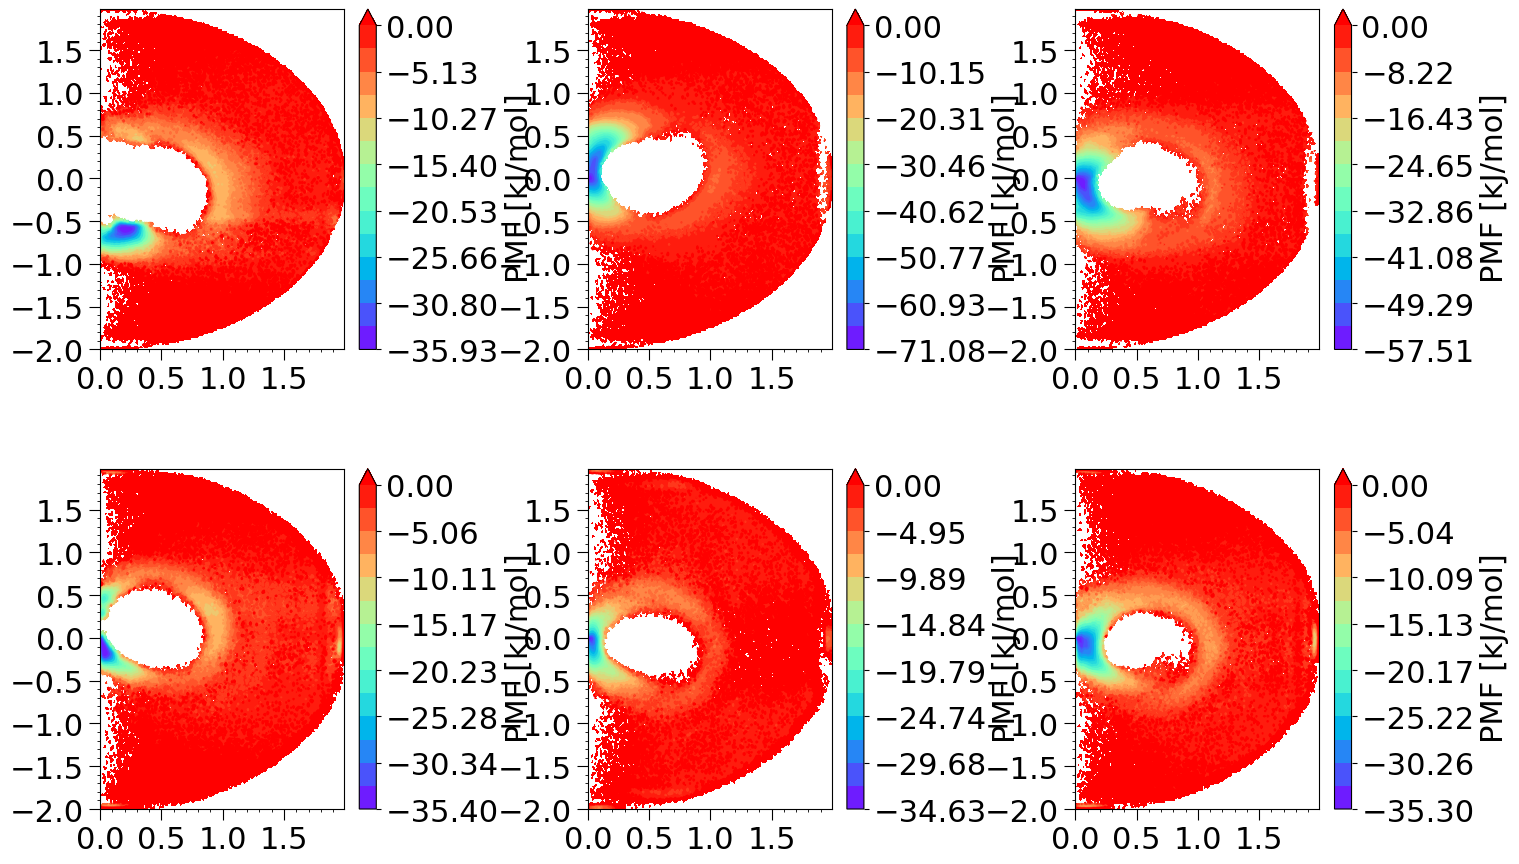

In [28]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

# Set the figure size
fig = plt.figure(figsize=(16, 10))

# Adjust spacing
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.6, hspace=0.35)

# Create a 3x3 grid
grid = GridSpec(2, 3)

probe= ['acd','bcd','gcd']
analyte = ['pfos','TCAA']

selected_block = 0 # entire data is used.

for k, kk in enumerate(analyte):
    for i, ii in enumerate(probe):
        
        # Create subplots
        ax = plt.subplot(grid[k, i])
        
        #selected_fe = pmf_probe_analyte_zero_ref_global_minima
        selected_fe = pmf_probe_analyte_zero_ref_boundary
        
        fe = selected_fe[ii+'_'+kk]['block'+str(selected_block)]['fe']
        xedges = selected_fe[ii+'_'+kk]['block'+str(selected_block)]['xedges']
        yedges = selected_fe[ii+'_'+kk]['block'+str(selected_block)]['yedges']
        
        x, y = np.meshgrid(xedges, yedges)
        contour_levels = np.linspace(fe.min(), 0, 15) 
        
        
        ax.contour(x[:-1, :-1], y[:-1, :-1], fe, cmap='rainbow', levels=contour_levels)
        contour_plot = ax.contourf(x[:-1, :-1], y[:-1, :-1], fe, cmap='rainbow', levels=contour_levels, extend='max')
        
        #print(fe.max(), np.isinf(fe).any(), np.isnan(fe).any())
        
        #if i==2:
        plt.colorbar(contour_plot, label='PMF [kJ/mol]')
        

        fe_beyond_cutoff = []
        print(xedges.min(), xedges.max(), yedges.min(), yedges.max())
        for ki in range(xedges.shape[0]-1):
            for kj in range(yedges.shape[0]-1):
                
#                 #if .98 <= xedges[ki]**2 + np.abs(yedges[kj])**2 <= 1.0:
#                 if .78 <= xedges[ki] <= 0.81 and -0.84  <= yedges[kj] <= 0.85:
#                     ax.scatter(xedges[ki], yedges[kj], c='magenta',s=10)
                
                if np.isnan(fe[kj,ki]) or np.isinf(fe[kj,ki]):
                    continue
                    
              #  if fe[kj,ki] > 5:
               #     ax.scatter(xedges[ki], yedges[kj], c='black',s=10)
                
                #if xedges[ki]**2 + np.abs(yedges[kj])**2 > 1.0:
                #if .99 <= xedges[ki] < 1.0 and -0.98**2 <= yedges[kj]**2 < 1.**2:
                if .99 <= xedges[ki] <= 1.01 and -0.94  <= yedges[kj] <= 0.95:
                    fe_beyond_cutoff.append(fe[kj,ki])

       # ax.set_xlabel('r [nm]')
#        ax.set_ylabel('z [nm]')
        #x.set_title(kk.upper()+':'+ii.upper())
        
        ax.xaxis.set_major_locator(MultipleLocator(0.5))
        ax.yaxis.set_major_locator(MultipleLocator(0.5))
        ax.xaxis.set_minor_locator(AutoMinorLocator(n=5))
        ax.yaxis.set_minor_locator(AutoMinorLocator(n=5))
        ax.tick_params(which='major', length=8)
        ax.tick_params(which='minor', length=2)
        plt.savefig('M1_cbar.png',dpi=300)
        

        

#### Compute deltaG and kb with 2D simpson, 50-500 blocks, cutoff 0.6-1.4 nm

In [11]:
V0 = 1661*1e-3
Vf = 32*np.pi/3
CP = V0/Vf
kb = 8.31446261815324*0.001 #kJ/molK
temperature = 300
kbt = kb*temperature  #kJ/mol
probe= ['acd','bcd','gcd']
analyte = ['TCAA','pfos']
#choose number of blocks
blocks = 1
#define dimensions in r and z directions
#dimz = 100
#dimr = 100

pmf_probe_analyte_zero_ref_boundary = {} # collect pmfs
pmf_probe_analyte_zero_ref_global_minima = {} # collect pmfs
dimvec = [50,100,250,500]
cutvec = [0.6,0.8,1,1.2,1.4]

deltag_kb_probe_analyte_block = {}
cutoff1 = np.sqrt(3.5)
overmat = []
iii = 0
for ii in probe:
    for kk in analyte:
        submatkb = np.zeros([len(dimvec),len(cutvec)])
        submatdG = np.zeros([len(dimvec),len(cutvec)])
        submatcut = np.zeros([len(dimvec),len(cutvec)])
        submatstd = np.zeros([len(dimvec),len(cutvec)])
        
        for ll in range(len(dimvec)):
            for mm in range(len(cutvec)):
                dimz = dimvec[ll]
                cutoff = cutvec[mm]
                dimr = dimz
                pmf_probe_analyte_zero_ref_global_minima[ii+'_'+kk] = {}
                pmf_probe_analyte_zero_ref_boundary[ii+'_'+kk]  = {}

                deltag_kb_probe_analyte_block[ii+'_'+kk] = {}

                #create holders
                fep = []
                avgFE,sdFE = [],[]
                avgkb,sdkb = [],[]
                #load data 
                colvarFile = '/project2/andrewferguson/maxtopel/PFAS_TACC/system-cd/reweights/'+kk+'-'+ii+"/COLVAR_reweight" #simDir + systemDir + colvarFileName

                colvarData = pd.read_csv(colvarFile, comment="#", 
                                         delim_whitespace=True,names=["time", "angle", "r", 
                                                                      "baxis","mag", "pr", "pz", "bias"],
                                         skip_blank_lines=True)

                # discard initial few frames [frames where free energy is still being mapped]
                # subsample and randomize
                if kk=='pfos': 
                    s = 50000
                    d = 500001
                    colvarD = colvarData[s:d].sample(frac = 1)
                else:
                    s = 100000
                    d = 1000000
                    colvarD = colvarData[s:d:2].sample(frac = 1)        
                jmp = len(colvarD)//blocks


                for jj in range(blocks): 
                    colvarData_init = colvarD[jmp*jj:jmp*(jj+1)] 
                    print(jmp*jj,jmp*(jj+1))


                    colvarData_2 = colvarData_init[(colvarData_init['r'] < cutoff1)]
                    colvarData_3 = colvarData_2[(colvarData_2['baxis'] < cutoff1)]
                    colvarData = colvarData_3[(colvarData_3['baxis'] >= -cutoff1)]
                    ############################################################################################################
                    #make a 2D heat map
                    bias = colvarData['bias'] 
                    r = colvarData['r']
                    z = colvarData['baxis']
                    
                    # calculate weights of each frame in colvarData - CHECK THIS APPROACH (SUMMING THE BIASES)
                    weights = np.exp((bias) /kbt)        
                    xedges = np.linspace(0,cutoff1,dimr)
                    yedges = np.linspace(-cutoff1,cutoff1,dimz)
                    #print(xedges,yedges)
                    dr,dz = abs(xedges[0]-xedges[1]),abs(yedges[0]-yedges[1])
                    # get unbiased probabilities
                    fe, xedges,yedges = np.histogram2d(r,z,range=[[0,cutoff1],[-cutoff1,cutoff1]],
                                                       bins=(xedges,yedges),
                                                       weights=weights,density=True)

                    fe = fe.T
                    feDf = -kbt*np.log(fe) # Compute free energy

                    ######## correction
                    #correction
                    for ki in range(xedges.shape[0]-1):
                        for kj in range(yedges.shape[0]-1):
        #                     if xedges[ki]**2 + np.abs(yedges[kj])**2 > 1.25: # 2.0:
                   
                            if np.isnan(feDf[kj,ki]) or np.isinf(feDf[kj,ki]):
                                continue
    
                            s = np.sqrt(xedges[ki]**2+yedges[kj]**2)
                            feDf[ki,kj] += preFactor*np.log(s)
####################################

            
                    # Find values of free energy on the boundary of the surface
                    avg_fe_beyond_cutoff=[]
                    for ki in range(xedges.shape[0]-1):
                        for kj in range(yedges.shape[0]-1):

                            if np.isnan(feDf[kj,ki]) or np.isinf(feDf[kj,ki]):
                                continue
                           # print(bool(xedges[ki]>0.8),ki, xedges[ki])
                            #if 1.48 <= xedges[ki] < 1.5 and -1.48**2 <= yedges[kj]**2 < 1.5**2:
                            if xedges[ki] > cutoff or yedges[kj] < -cutoff or yedges[kj] > cutoff:
                                avg_fe_beyond_cutoff.append(feDf[kj,ki])
                        



                    avg_fe_beyond_cutoff = np.array(avg_fe_beyond_cutoff)
                 #   print(avg_fe_beyond_cutoff,len(avg_fe_beyond_cutoff))
                    cutmean = avg_fe_beyond_cutoff.mean()
                    cutstd = avg_fe_beyond_cutoff.std()
                    feDf_zero_ref_boundary = feDf - avg_fe_beyond_cutoff.mean() #collect_fe_k_max # UNCOMMENT THIS FOR SETTING BOUNDARY FREE ENERGY TO ZERO
                    _block_data_boundary = {'fe': feDf_zero_ref_boundary,
                                            'xedges': xedges,
                                            'yedges': yedges}

                    pmf_probe_analyte_zero_ref_boundary[ii+'_'+kk]['block'+str(jj)] = _block_data_boundary

                    selected_fe = pmf_probe_analyte_zero_ref_boundary[ii+'_'+kk]['block'+str(jj)]['fe']


                    ##Compute deltaG and kb
                    ##Also visualize the cutoff area for bounded region
                    print('Computing free energies ...')
                    dgh=0
                    dgh_unbound = 0
                    #simulation_volume = 0 # term 1/C in Kb. 1/(simulation concentration)

                    for ki in range(xedges.shape[0]-1):
                        for kj in range(yedges.shape[0]-1):

                           
                            # integrate below the upper cutoff of the above region.
                            if xedges[ki] < cutoff and (yedges[kj] > -cutoff and yedges[kj] < cutoff):
                
                                # convert selected_fe to probability (redundant step; done previously for visualization)
                                #dgh += np.exp(-selected_fe/kbt)[kj,ki]*dr*dz*xedges[ki]
                                dgh += np.exp(-selected_fe[kj,ki]/kbt)*dr*dz*xedges[ki]

                    dg = -kbt*np.log(2*np.pi*dgh*(1/V0))
                    kb = (1/V0)*2*np.pi*dgh

                    print(f'{ii.upper()}:{kk.upper()} Block:{jj} Kb:{kb} dG:{dg} kJ/mol cutmean:{cutmean} cutstd:{cutstd}')
                    print(f'{ii.upper()}:{kk.upper()}', f' dimz: {dimz} cutoff: {cutoff}')
                    deltag_kb_probe_analyte_block[ii+'_'+kk]['block'+str(jj)] = {'deltag': dg, 'kb': kb}
                submatkb[ll,mm] = kb
                submatdG[ll,mm] = dg
                submatcut[ll,mm] = cutmean
                submatstd[ll,mm] = cutstd
            
        overmat.append([submatkb,submatdG,submatcut,submatstd])
    

0 450000
Computing free energies ...
ACD:TCAA Block:0 Kb:7.20328343137247 dG:-4.92516410817244 kJ/mol cutmean:13.507150257378198 cutstd:3.5105387790739933
ACD:TCAA  dimz: 50 cutoff: 0.6
0 450000
Computing free energies ...
ACD:TCAA Block:0 Kb:9.13358754230741 dG:-5.517374021616558 kJ/mol cutmean:13.513934749823827 cutstd:3.493687434119402
ACD:TCAA  dimz: 50 cutoff: 0.8
0 450000
Computing free energies ...
ACD:TCAA Block:0 Kb:23.709268848340415 dG:-7.896742508802689 kJ/mol cutmean:13.75563866946357 cutstd:3.377199246021308
ACD:TCAA  dimz: 50 cutoff: 1
0 450000
Computing free energies ...
ACD:TCAA Block:0 Kb:32.56539316024092 dG:-8.688405986014192 kJ/mol cutmean:13.875648756992003 cutstd:3.438305301302426
ACD:TCAA  dimz: 50 cutoff: 1.2
0 450000
Computing free energies ...
ACD:TCAA Block:0 Kb:46.91276111052489 dG:-9.598938332047396 kJ/mol cutmean:14.191985507602386 cutstd:3.5735907405031546
ACD:TCAA  dimz: 50 cutoff: 1.4
0 450000
Computing free energies ...
ACD:TCAA Block:0 Kb:9.032232782

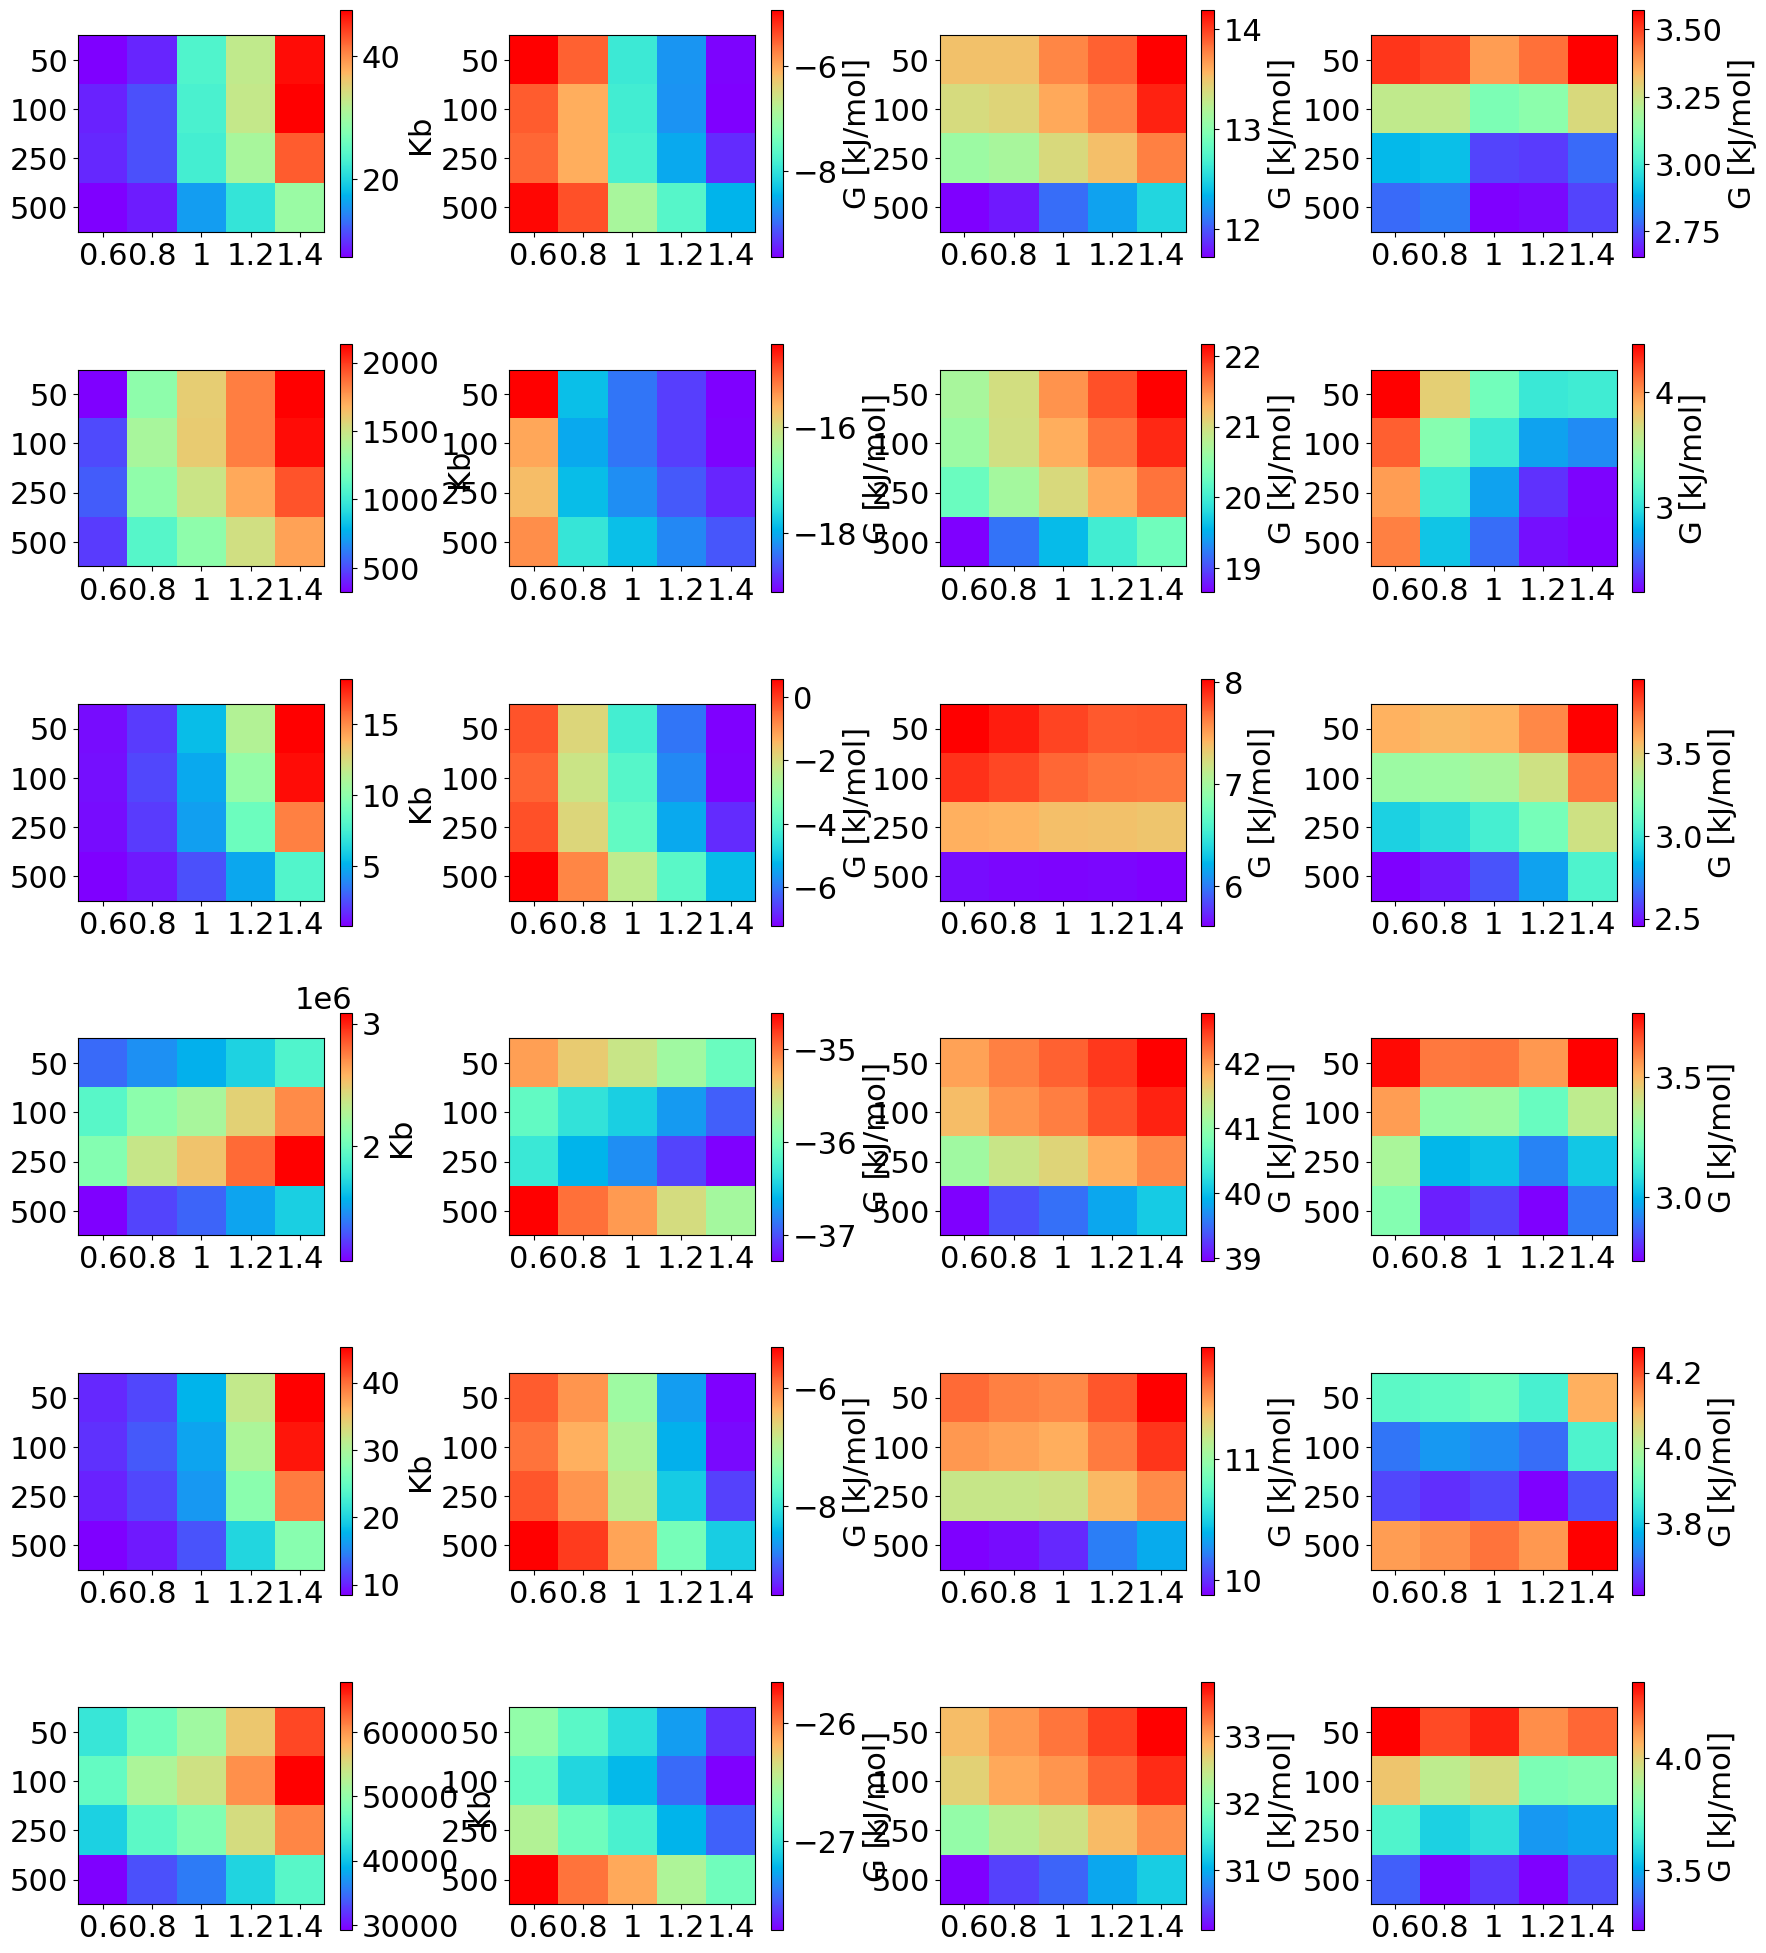

In [12]:
fig = plt.figure(figsize=(20, 24))
dimvec = [50,100,250,500]
cutvec = [0.6,0.8,1,1.2,1.4]
# Adjust spacing
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.35)
#plt.setp(axs,xticks=[0,1,2,3,4], xticklabels=cutvec,yticks=[0,1,2,3],yticklabels=dimvec)
# Create a 6x4 grid -  each system - heat map for Kb, dG, cutmean, cutstd 
grid = GridSpec(6, 4)

probe= ['acd','bcd','gcd']
analyte = ['TCAA','pfos']


selected_block = 0 # entire data is used.
iii = 0
for k, kk in enumerate(analyte):
    for i, ii in enumerate(probe):
        submatkb,submatdG,submatcut,submatstd = overmat[iii]
        
        # Create subplots
        axa = plt.subplot(grid[iii,0])
        plt.setp(axa,xticks=[0,1,2,3,4], xticklabels=cutvec,yticks=[0,1,2,3],yticklabels=dimvec)
        ax1 = axa.imshow(submatkb, cmap='rainbow')
        plt.colorbar(ax1, label='Kb')
        axb = plt.subplot(grid[iii,1])
        plt.setp(axb,xticks=[0,1,2,3,4], xticklabels=cutvec,yticks=[0,1,2,3],yticklabels=dimvec)
        ax2 = axb.imshow(submatdG, cmap='rainbow')
        plt.colorbar(ax2, label='G [kJ/mol]')
        axc = plt.subplot(grid[iii,2])
        plt.setp(axc,xticks=[0,1,2,3,4], xticklabels=cutvec,yticks=[0,1,2,3],yticklabels=dimvec)
        ax3 = axc.imshow(submatcut, cmap='rainbow')
        plt.colorbar(ax3, label='G [kJ/mol]')
        axd = plt.subplot(grid[iii,3])
        plt.setp(axd,xticks=[0,1,2,3,4], xticklabels=cutvec,yticks=[0,1,2,3],yticklabels=dimvec)
        ax4 = axd.imshow(submatstd, cmap='rainbow')
        plt.colorbar(ax4, label='G [kJ/mol]')
        
        iii+=1

In [29]:
V0 = 1661*1e-3
Vf = 32*np.pi/3
CP = V0/Vf
kb = 8.31446261815324*0.001 #kJ/molK
temperature = 300
kbt = kb*temperature  #kJ/mol
probe= ['acd','bcd','gcd']
analyte = ['TCAA','pfos']
#choose number of blocks
blocks = 3
#define dimensions in r and z directions
#dimz = 100
#dimr = 100

pmf_probe_analyte_zero_ref_boundary = {} # collect pmfs
pmf_probe_analyte_zero_ref_global_minima = {} # collect pmfs
dimvec = [200]
cutvec = [0.8,1,1.2,1.4,1.6]

deltag_kb_probe_analyte_block = {}
cutoff1 = np.sqrt(3.5)
dgs = []
kbs = []
kbe = []
dge = []
iii = 0
for ii in probe:
    for kk in analyte:
        kbvec = []
        dgvec = []
        kberrs = []
        dgerrs = []
    
        for ll in range(len(dimvec)):
            for mm in range(len(cutvec)):
                dimz = dimvec[ll]
                cutoff = cutvec[mm]
                dimr = dimz
                pmf_probe_analyte_zero_ref_global_minima[ii+'_'+kk] = {}
                pmf_probe_analyte_zero_ref_boundary[ii+'_'+kk]  = {}

                deltag_kb_probe_analyte_block[ii+'_'+kk] = {}

                #create holders
                fep = []
                avgFE,sdFE = [],[]
                avgkb,sdkb = [],[]
                #load data 
                colvarFile = '/project2/andrewferguson/maxtopel/PFAS_TACC/system-cd/reweights/'+kk+'-'+ii+"/COLVAR_reweight" #simDir + systemDir + colvarFileName

                colvarData = pd.read_csv(colvarFile, comment="#", 
                                         delim_whitespace=True,names=["time", "angle", "r", 
                                                                      "baxis","mag", "pr", "pz", "bias"],
                                         skip_blank_lines=True)

                # discard initial few frames [frames where free energy is still being mapped]
                # subsample and randomize
                if kk=='pfos': 
                    s = 50000
                    d = 500001
                    colvarD = colvarData[s:d].sample(frac = 1)
                else:
                    s = 100000
                    d = 1000000
                    colvarD = colvarData[s:d:2].sample(frac = 1)        
                jmp = len(colvarD)//blocks

                lockb = []
                locdg = []
                for jj in range(blocks): 
                    colvarData_init = colvarD[jmp*jj:jmp*(jj+1)] 
                    print(jmp*jj,jmp*(jj+1))


                    colvarData_2 = colvarData_init[(colvarData_init['r'] < cutoff1)]
                    colvarData_3 = colvarData_2[(colvarData_2['baxis'] < cutoff1)]
                    colvarData = colvarData_3[(colvarData_3['baxis'] >= -cutoff1)]
                    ############################################################################################################
                    #make a 2D heat map
                    bias = colvarData['bias'] 
                    r = colvarData['r']
                    z = colvarData['baxis']
                    
                    # calculate weights of each frame in colvarData - CHECK THIS APPROACH (SUMMING THE BIASES)
                    weights = np.exp((bias) /kbt)        
                    xedges = np.linspace(0,cutoff1,dimr)
                    yedges = np.linspace(-cutoff1,cutoff1,dimz)
                    #print(xedges,yedges)
                    dr,dz = abs(xedges[0]-xedges[1]),abs(yedges[0]-yedges[1])
                    # get unbiased probabilities
                    fe, xedges,yedges = np.histogram2d(r,z,range=[[0,cutoff1],[-cutoff1,cutoff1]],
                                                       bins=(xedges,yedges),
                                                       weights=weights,density=True)

                    fe = fe.T
                    feDf = -kbt*np.log(fe) # Compute free energy

                    ######## correction
                    #correction
                    for ki in range(xedges.shape[0]-1):
                        for kj in range(yedges.shape[0]-1):
        #                     if xedges[ki]**2 + np.abs(yedges[kj])**2 > 1.25: # 2.0:
                   
                            if np.isnan(feDf[kj,ki]) or np.isinf(feDf[kj,ki]):
                                continue
    
                            s = np.sqrt(xedges[ki]**2+yedges[kj]**2)
                            feDf[ki,kj] += preFactor*np.log(s)
####################################

            
                    # Find values of free energy on the boundary of the surface
                    avg_fe_beyond_cutoff=[]
                    for ki in range(xedges.shape[0]-1):
                        for kj in range(yedges.shape[0]-1):

                            if np.isnan(feDf[kj,ki]) or np.isinf(feDf[kj,ki]):
                                continue
                           # print(bool(xedges[ki]>0.8),ki, xedges[ki])
                            #if 1.48 <= xedges[ki] < 1.5 and -1.48**2 <= yedges[kj]**2 < 1.5**2:
                            if xedges[ki] > cutoff or yedges[kj] < -cutoff or yedges[kj] > cutoff:
                                avg_fe_beyond_cutoff.append(feDf[kj,ki])
                        



                    avg_fe_beyond_cutoff = np.array(avg_fe_beyond_cutoff)
                 #   print(avg_fe_beyond_cutoff,len(avg_fe_beyond_cutoff))
                    cutmean = avg_fe_beyond_cutoff.mean()
                    cutstd = avg_fe_beyond_cutoff.std()
                    feDf_zero_ref_boundary = feDf - avg_fe_beyond_cutoff.mean() #collect_fe_k_max # UNCOMMENT THIS FOR SETTING BOUNDARY FREE ENERGY TO ZERO
                    _block_data_boundary = {'fe': feDf_zero_ref_boundary,
                                            'xedges': xedges,
                                            'yedges': yedges}

                    pmf_probe_analyte_zero_ref_boundary[ii+'_'+kk]['block'+str(jj)] = _block_data_boundary

                    selected_fe = pmf_probe_analyte_zero_ref_boundary[ii+'_'+kk]['block'+str(jj)]['fe']


                    ##Compute deltaG and kb
                    ##Also visualize the cutoff area for bounded region
                    print('Computing free energies ...')
                    dgh=0
                    dgh_unbound = 0
                    #simulation_volume = 0 # term 1/C in Kb. 1/(simulation concentration)

                    for ki in range(xedges.shape[0]-1):
                        for kj in range(yedges.shape[0]-1):

                           
                            # integrate below the upper cutoff of the above region.
                            if xedges[ki] < cutoff and (yedges[kj] > -cutoff and yedges[kj] < cutoff):
                
                                # convert selected_fe to probability (redundant step; done previously for visualization)
                                #dgh += np.exp(-selected_fe/kbt)[kj,ki]*dr*dz*xedges[ki]
                                dgh += np.exp(-selected_fe[kj,ki]/kbt)*dr*dz*xedges[ki]

                    dg = -kbt*np.log(2*np.pi*dgh*(1/V0))
                    kb = (1/V0)*2*np.pi*dgh

                    print(f'{ii.upper()}:{kk.upper()} Block:{jj} Kb:{kb} dG:{dg} kJ/mol cutmean:{cutmean} cutstd:{cutstd}')
                    print(f'{ii.upper()}:{kk.upper()}', f' dimz: {dimz} cutoff: {cutoff}')
                    deltag_kb_probe_analyte_block[ii+'_'+kk]['block'+str(jj)] = {'deltag': dg, 'kb': kb}
                    lockb.append(kb)
                    locdg.append(dg)

                kbvec.append(np.mean(lockb))
                kberrs.append(np.std(lockb))
                dgvec.append(np.mean(locdg))
                dgerrs.append(np.std(locdg))
            kbs.append(kbvec)
            kbe.append(kberrs)
            dgs.append(dgvec)
            dge.append(dgerrs)

    

0 150000
Computing free energies ...
ACD:TCAA Block:0 Kb:9.723994118144313 dG:-5.673614150397388 kJ/mol cutmean:12.77878517132987 cutstd:2.8452750405797578
ACD:TCAA  dimz: 200 cutoff: 0.8
150000 300000
Computing free energies ...
ACD:TCAA Block:1 Kb:10.121672236148454 dG:-5.773593333511506 kJ/mol cutmean:12.806444797509235 cutstd:2.85710781927752
ACD:TCAA  dimz: 200 cutoff: 0.8
300000 450000
Computing free energies ...
ACD:TCAA Block:2 Kb:9.878387785232214 dG:-5.712907138132945 kJ/mol cutmean:12.801334968163054 cutstd:2.862817993355545
ACD:TCAA  dimz: 200 cutoff: 0.8
0 150000
Computing free energies ...
ACD:TCAA Block:0 Kb:20.109637242702572 dG:-7.486007480031684 kJ/mol cutmean:13.042802445694774 cutstd:2.673666436943323
ACD:TCAA  dimz: 200 cutoff: 1
150000 300000
Computing free energies ...
ACD:TCAA Block:1 Kb:19.93037917013712 dG:-7.463673156001906 kJ/mol cutmean:13.067080535875306 cutstd:2.7797486222139884
ACD:TCAA  dimz: 200 cutoff: 1
300000 450000
Computing free energies ...
ACD:T

# Compute delta G and Kb

In [32]:
for val in range(len(kbs)):
    print(dgs[val])

print('')
for val in range(len(kbs)):
    print(dge[val])
    
#for val in range(len(kbs)):   
#    print(dgs[val])

[-5.7200382073472795, -7.484470595912637, -8.250763174358832, -9.084126804773986, -9.624274938684275]
[-17.87011733761253, -18.22462385809988, -18.566354126466976, -18.8894030013694, -19.09781815990816]
[-1.5450884997902257, -3.292139536741358, -4.943362401739862, -6.222418974019682, -7.255932769351435]
[-35.9540866901832, -36.09337499971778, -36.377446956800306, -36.652321456197676, -36.612331902249046]
[-5.910189051497838, -6.676185901514162, -8.014248915503776, -8.86051677687314, -9.869536007367854]
[-26.40249897718851, -26.552808005198035, -26.79731450233781, -27.046318740632714, -27.134240831065142]

[0.04112662053663337, 0.0163896769242154, 0.01196334070130817, 0.01720912060862414, 0.0039055039784602528]
[0.09013664029754029, 0.0966940748147446, 0.036868351042161344, 0.012591885414498906, 0.0791308567635146]
[0.05617909789397924, 0.005958473382739755, 0.00682432228066177, 0.011512462728160852, 0.008491774482498101]
[0.05407834184133674, 0.007287578077184259, 0.04432608541199907, 

0 150000
Computing free energies ...
ACD:TCAA Block:0 Kb:30.916901151092066 dG:-8.558832150514446 kJ/mol cutmean:12.10937642134874 cutstd:2.1906026057456898
ACD:TCAA  dimz: 200 cutoff: 1
150000 300000
Computing free energies ...
ACD:TCAA Block:1 Kb:30.396472038775933 dG:-8.51648714064522 kJ/mol cutmean:12.085008462095491 cutstd:2.116570554047201
ACD:TCAA  dimz: 200 cutoff: 1
300000 450000
Computing free energies ...
ACD:TCAA Block:2 Kb:30.574198697171887 dG:-8.53102894402367 kJ/mol cutmean:12.088044621432388 cutstd:2.14446493059727
ACD:TCAA  dimz: 200 cutoff: 1
0 150000
Computing free energies ...
ACD:PFOS Block:0 Kb:2131.644165226397 dG:-19.118230951999212 kJ/mol cutmean:19.758602297550166 cutstd:2.078250559270455
ACD:PFOS  dimz: 200 cutoff: 1
150000 300000
Computing free energies ...
ACD:PFOS Block:1 Kb:2145.2888867120682 dG:-19.13414640967608 kJ/mol cutmean:19.766160106451842 cutstd:2.053060532223804
ACD:PFOS  dimz: 200 cutoff: 1
300000 450000
Computing free energies ...
ACD:PFOS Bl

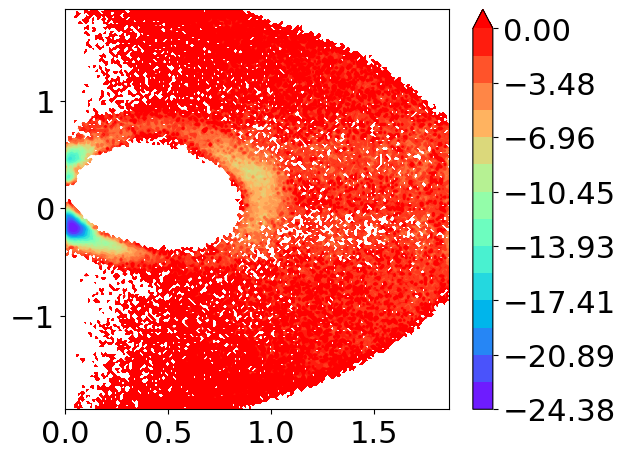

In [3]:
#CIRCULAR
V0 = 1661*1e-3
Vf = 32*np.pi/3
CP = V0/Vf
C0 = 1/(1661*1e-3)
kb = 8.31446261815324*0.001 #kJ/molK
temperature = 300
kbt = kb*temperature  #kJ/mol
probe= ['acd','bcd','gcd']
analyte = ['TCAA','pfos']
#choose number of blocks
blocks = 3
#define dimensions in r and z directions
#dimz = 100
#dimr = 100

pmf_probe_analyte_zero_ref_boundary = {} # collect pmfs
pmf_probe_analyte_zero_ref_global_minima = {} # collect pmfs
dimvec = [50,100,250,500]
cutvec = [0.6,0.8,1,1.2,1.4]

deltag_kb_probe_analyte_block = {}
cutoff1 = np.sqrt(3.5)
overmat = []
iii = 0
for ii in probe:
    for kk in analyte:
       
                dimz = 200 #dimvec[ll]
                cutoff = 1 #cutvec[mm]
                dimr = dimz
                pmf_probe_analyte_zero_ref_global_minima[ii+'_'+kk] = {}
                pmf_probe_analyte_zero_ref_boundary[ii+'_'+kk]  = {}

                deltag_kb_probe_analyte_block[ii+'_'+kk] = {}

                #create holders
                fep = []
                avgFE,sdFE = [],[]
                avgkb,sdkb = [],[]
                #load data 
                colvarFile = '/project2/andrewferguson/maxtopel/PFAS_TACC/system-cd/reweights/'+kk+'-'+ii+"/COLVAR_reweight" #simDir + systemDir + colvarFileName

                colvarData = pd.read_csv(colvarFile, comment="#", 
                                         delim_whitespace=True,names=["time", "angle", "r", 
                                                                      "baxis","mag", "pr", "pz", "bias"],
                                         skip_blank_lines=True)

                # discard initial few frames [frames where free energy is still being mapped]
                # subsample and randomize
                if kk=='pfos': 
                    s = 50000
                    d = 500001
                    colvarD = colvarData[s:d].sample(frac = 1)
                else:
                    s = 100000
                    d = 1000000
                    colvarD = colvarData[s:d:2].sample(frac = 1)        
                jmp = len(colvarD)//blocks


                for jj in range(blocks): 
                    colvarData_init = colvarD[jmp*jj:jmp*(jj+1)] 
                    print(jmp*jj,jmp*(jj+1))


                    colvarData_2 = colvarData_init[(colvarData_init['r'] < cutoff1)]
                    colvarData_3 = colvarData_2[(colvarData_2['baxis'] < cutoff1)]
                    colvarData = colvarData_3[(colvarData_3['baxis'] >= -cutoff1)]
                    ############################################################################################################
                    #make a 2D heat map
                    bias = colvarData['bias'] 
                    r = colvarData['r']
                    z = colvarData['baxis']
                    
                    # calculate weights of each frame in colvarData - CHECK THIS APPROACH (SUMMING THE BIASES)
                    weights = np.exp((bias) /kbt)        
                    xedges = np.linspace(0,cutoff1,dimr)
                    yedges = np.linspace(-cutoff1,cutoff1,dimz)
                    #print(xedges,yedges)
                    dr,dz = abs(xedges[0]-xedges[1]),abs(yedges[0]-yedges[1])
                    # get unbiased probabilities
                    fe, xedges,yedges = np.histogram2d(r,z,range=[[0,cutoff1],[-cutoff1,cutoff1]],
                                                       bins=(xedges,yedges),
                                                       weights=weights,density=True)

                    fe = fe.T
                    feDf = -kbt*np.log(fe) # Compute free energy

            
                    # Find values of free energy on the boundary of the surface
                    avg_fe_beyond_cutoff=[]
                    for ki in range(xedges.shape[0]-1):
                        for kj in range(yedges.shape[0]-1):

                            if np.isnan(feDf[kj,ki]) or np.isinf(feDf[kj,ki]):
                                continue
                            s = np.sqrt(xedges[ki]**2+yedges[kj]**2)
                            if s > 1.2: #xedges[ki] > cutoff or yedges[kj] < -cutoff or yedges[kj] > cutoff:
                                avg_fe_beyond_cutoff.append(feDf[kj,ki])
                        



                    avg_fe_beyond_cutoff = np.array(avg_fe_beyond_cutoff)
                 #   print(avg_fe_beyond_cutoff,len(avg_fe_beyond_cutoff))
                    cutmean = avg_fe_beyond_cutoff.mean()
                    cutstd = avg_fe_beyond_cutoff.std()
                    feDf_zero_ref_boundary = feDf - avg_fe_beyond_cutoff.mean() #collect_fe_k_max # UNCOMMENT THIS FOR SETTING BOUNDARY FREE ENERGY TO ZERO
                    _block_data_boundary = {'fe': feDf_zero_ref_boundary,
                                            'xedges': xedges,
                                            'yedges': yedges}

                    pmf_probe_analyte_zero_ref_boundary[ii+'_'+kk]['block'+str(jj)] = _block_data_boundary

                    selected_fe = pmf_probe_analyte_zero_ref_boundary[ii+'_'+kk]['block'+str(jj)]['fe']
                    
                    
                    if ii == 'acd' and kk == 'TCAA' and jj == 0:
                        
                        
                        fig = plt.figure(figsize=(6, 5))
                        plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.6, hspace=0.35)
                        grid = GridSpec(1, 1)
                        ax = plt.subplot(grid[0, 0])
                        
                        fe = feDf_zero_ref_boundary
        
                        x, y = np.meshgrid(xedges, yedges)
                        contour_levels = np.linspace(fe.min(), 0, 15) 

                        ax.contour(x[:-1, :-1], y[:-1, :-1], fe, cmap='rainbow', levels=contour_levels,vmin=fe.min(),vmax=0)
                        cb = contour_plot = ax.contourf(x[:-1, :-1], y[:-1, :-1], fe, cmap='rainbow', levels=contour_levels, extend='max',vmin=fe.min(),vmax=0)
                           
                        cbar = plt.colorbar(cb, ax=ax)
                        


                    ##Compute deltaG and kb
                    ##Also visualize the cutoff area for bounded region
                    print('Computing free energies ...')
                    dgh=0
                    dgh_unbound = 0
                    #simulation_volume = 0 # term 1/C in Kb. 1/(simulation concentration)

                    for ki in range(xedges.shape[0]-1):
                        for kj in range(yedges.shape[0]-1):

                            s = np.sqrt(xedges[ki]**2+yedges[kj]**2)
                            # integrate below the upper cutoff of the above region.
                            if s<1.2:#xedges[ki] < cutoff and (yedges[kj] > -cutoff and yedges[kj] < cutoff):
                
                                # convert selected_fe to probability (redundant step; done previously for visualization)
                                dgh += np.exp(-selected_fe[kj,ki]/kbt)*dr*dz*xedges[ki]

                    
                    
                    dg = -kbt*np.log(2*np.pi*dgh*(1/V0))
                    kb = (1/V0)*2*np.pi*dgh

                    print(f'{ii.upper()}:{kk.upper()} Block:{jj} Kb:{kb} dG:{dg} kJ/mol cutmean:{cutmean} cutstd:{cutstd}')
                    print(f'{ii.upper()}:{kk.upper()}', f' dimz: {dimz} cutoff: {cutoff}')
                    deltag_kb_probe_analyte_block[ii+'_'+kk]['block'+str(jj)] = {'deltag': dg, 'kb': kb}

    

#### Plot free energies and kb

[-8.533597487807242, -3.9042909908375694, -8.593137146840178, -19.127936873956326, -36.67607651218133, -28.92081827311159]
[0.01256865984370343, 0.0128121208002618, 0.0225160517766876, 0.011359201080316437, 0.023328177171248857, 0.015348209770109275]
['acd_TCAA', 'bcd_TCAA', 'gcd_TCAA', 'acd_pfos', 'bcd_pfos', 'gcd_pfos']
[30.60608758943657, 4.783985999367644, 31.346321702027108, 2139.977112158412, 2430896.766287753, 108510.47971285872]
[0.15443979885354114, 0.024547438762571833, 0.2834634927241676, 9.736248022232664, 22786.671455571202, 669.0223672961288]
[6.99199826e+01 5.08132082e+05 3.46166548e+03]
[4.75056499e-01 5.43003952e+03 3.78872299e+01]
['acd_TCAA', 'bcd_TCAA', 'gcd_TCAA', 'acd_pfos', 'bcd_pfos', 'gcd_pfos']


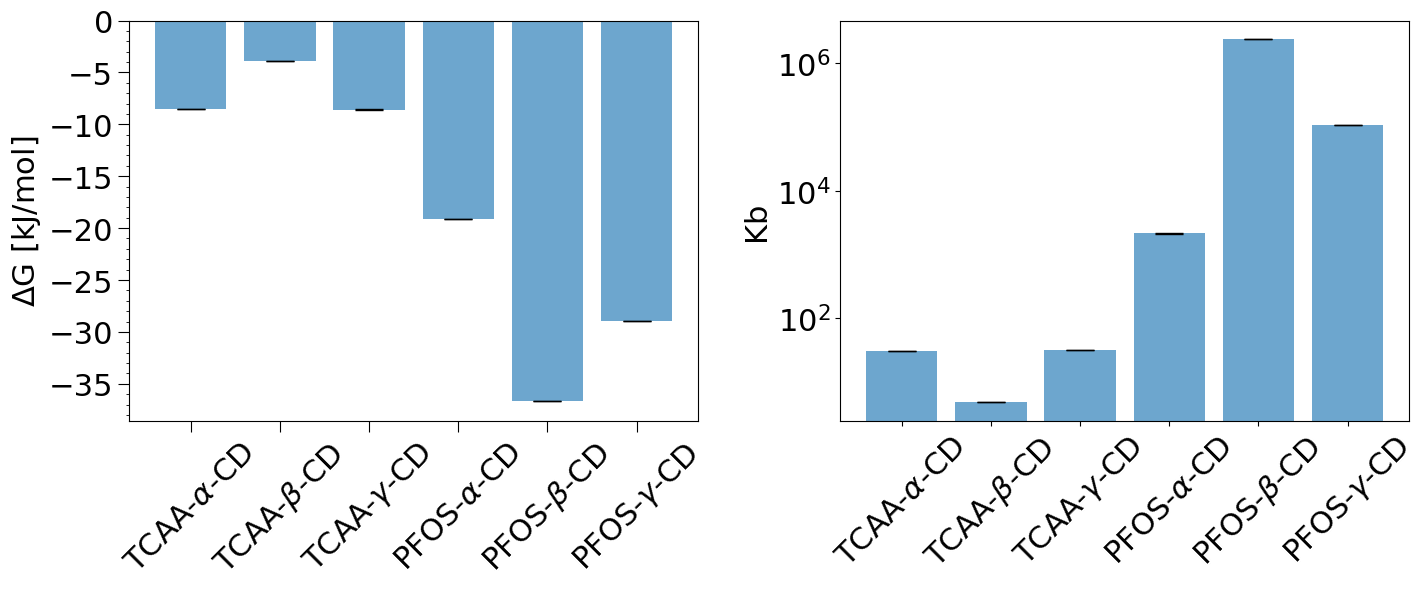

In [12]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
from operator import add
# Set the figure size
fig = plt.figure(figsize=(16, 5))
lbl = ['TCAA-$\\alpha$-CD','TCAA-$\\beta$-CD','TCAA-$\\gamma$-CD','PFOS-$\\alpha$-CD','PFOS-$\\beta$-CD','PFOS-$\\gamma$-CD']

# Adjust spacing
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.25, hspace=0.25)

# Create a 3x3 grid
grid = GridSpec(1, 2)

probe= ['acd','bcd','gcd']
analyte = ['TCAA','pfos']

blocks = 3

deltag_kb_probe_analyte = {}
kji = 0
for k, kk in enumerate(analyte):
    for i, ii in enumerate(probe):
        
        selected_data = deltag_kb_probe_analyte_block
        
        deltag_blocks = []
        kb_blocks = []
        for bb in range(blocks):
            deltag = selected_data[ii+'_'+kk]['block'+str(bb)]['deltag']
            kb = selected_data[ii+'_'+kk]['block'+str(bb)]['kb']
            deltag_blocks.append(deltag)
            kb_blocks.append(kb)
            
            #print(deltag, kb)
            
        deltag_blocks = np.array(deltag_blocks)
        kb_blocks = np.array(kb_blocks)
        
        
        deltag_kb_probe_analyte[ii+'_'+kk] = {'avg_deltag': np.mean(deltag_blocks),
                                              'sd_deltag': np.std(deltag_blocks),
                                              'avg_kb': np.mean(kb_blocks),
                                              'sd_kb': np.std(kb_blocks)}

        
        
   

def convert_dict_of_dict(input_dict):
    result_dict = {}

    # Iterate through outer keys
    for outer_key, inner_dict in input_dict.items():
        # Iterate through inner keys
        for inner_key, value in inner_dict.items():
            # Check if the inner key is already in the result dictionary
            if inner_key not in result_dict:
                result_dict[inner_key] = {}

            # Add the value corresponding to the outer key
            result_dict[inner_key][outer_key] = value

    return result_dict

deltag_kb_probe_analyte = convert_dict_of_dict(deltag_kb_probe_analyte)



# # Create subplots
ax = plt.subplot(grid[0, 0])
# Extract keys and values from the dictionary
categories = list(deltag_kb_probe_analyte['avg_deltag'].keys())
values = list(deltag_kb_probe_analyte['avg_deltag'].values())
errors = list(deltag_kb_probe_analyte['sd_deltag'].values())
print(values)
print(errors)


# Plotting a bar chart
ax.bar(categories, values, yerr=errors, align='center', alpha=0.65, ecolor='black', capsize=10)
print(categories)
ax.set_xticks(categories, ['TCAA-$\\alpha$-CD','TCAA-$\\beta$-CD','TCAA-$\\gamma$-CD','PFOS-$\\alpha$-CD','PFOS-$\\beta$-CD','PFOS-$\\gamma$-CD'], rotation=45)
    
ax.set_ylabel(r'$\Delta$G [kJ/mol]')

#ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(5))
#ax.xaxis.set_minor_locator(AutoMinorLocator(n=5))
ax.yaxis.set_minor_locator(AutoMinorLocator(n=5))
ax.tick_params(which='major', length=8)
ax.tick_params(which='minor', length=2)


# # Create subplots
ax = plt.subplot(grid[0, 1])
# Extract keys and values from the dictionary
categories = list(deltag_kb_probe_analyte['avg_kb'].keys())
values = list(deltag_kb_probe_analyte['avg_kb'].values())
errors = list(deltag_kb_probe_analyte['sd_kb'].values())
print(values)
print(errors)
values1 = values[0:3]
values2 = values[3::]
errors1 = errors[0:3]
errors2 = errors[3::]

print(np.divide(values2,values1))

print(np.multiply(np.sqrt(list(map(add,np.square(np.divide(errors1,values1)),np.square(np.divide(errors2,values2))))),np.divide(values2,values1)))
# Plotting a bar chart
ax.bar(categories, values, yerr=errors, align='center', alpha=0.65, ecolor='black', capsize=10)
print(categories)
ax.set_xticks(categories, ['TCAA-$\\alpha$-CD','TCAA-$\\beta$-CD','TCAA-$\\gamma$-CD','PFOS-$\\alpha$-CD','PFOS-$\\beta$-CD','PFOS-$\\gamma$-CD'], rotation=45)
    
ax.set_ylabel(r'Kb')
ax.set_yscale('log')

#ax.xaxis.set_major_locator(MultipleLocator(0.5))
# ax.yaxis.set_major_locator(MultipleLocator(1000))
# #ax.xaxis.set_minor_locator(AutosjbrgbrgbMinorLocator(n=5))
# ax.yaxis.set_minor_gmajor', length=8)
# ax.tick_params(which='minor', length=2)
        



In [63]:
############## PRODUCTION RUNNNNNN

C0 = 1/(1661*1e-3)
kb = 8.31446261815324*0.001 #kJ/molK
temperature = 300
kbt = kb*temperature  #kJ/mol
probe= ['acd']
analyte = ['pfos']
#choose number of blocks
preFactor = 2*kbt #kJ/mol for entropy correction
blocks = 3 #3
cutoff1 = np.sqrt(3.5)
cutoff2 = 2
sfes_mast = []
smast = []
DG = []
ERR = []
dvec = np.linspace(0,1,101)[1:]
for dp in dvec:
    for cutoff in [1]:
        dimz = dimr
        pmf_probe_analyte_zero_ref_boundary = {} # collect pmfs
        pmf_probe_analyte_zero_ref_global_minima = {} # collect pmfs

        #for ii in probe:
        for kk in analyte:
            for ii in probe:
                dgs = []
                pmf_probe_analyte_zero_ref_global_minima[ii+'_'+kk] = {}
                pmf_probe_analyte_zero_ref_boundary[ii+'_'+kk]  = {}

                #create holders
                fep = []
                avgFE,sdFE = [],[]
                avgkb,sdkb = [],[]
                #load data 
                colvarFile = '/project2/andrewferguson/maxtopel/PFAS_TACC/system-cd/reweights/'+kk+'-'+ii+"/COLVAR_reweight" #simDir + systemDir + colvarFileName
                #print(colvarFile)
                colvarData = pd.read_csv(colvarFile, comment="#", 
                                         delim_whitespace=True,names=["time", "angle", "r", 
                                                                      "baxis","mag", "pr", "pz", "bias"],
                                         skip_blank_lines=True)
                print(len(colvarData))
                # discard initial few frames [frames where free energy is still being mapped]
                # subsample and randomize
                #if kk=='pfos': #probe=='acd' or probe=='gcd' and analyte=='pfos':

                s = 0 #50000
                d = int(len(colvarData)*dp) #d = -1 #500001
                colvarD = colvarData[s:d].sample(frac = 1)

                print(len(colvarD))
   
                jmp = len(colvarD)//blocks

                print(ii,kk, len(colvarD), blocks, jmp)

                #\print(colvarD)
                for jj in range(blocks): 
                    colvarData_init = colvarD[jmp*jj:jmp*(jj+1)] 
                    print(jmp*jj,jmp*(jj+1))


                    colvarData_2 = colvarData_init[(colvarData_init['r'] < cutoff1)]
                    colvarData_3 = colvarData_2[(colvarData_2['baxis'] < cutoff1)]
                    colvarData = colvarData_3[(colvarData_3['baxis'] >= -cutoff1)]
                    ############################################################################################################
                    #make a 2D heat map
                    bias = colvarData['bias'] 
                    r = colvarData['r']
                    z = colvarData['baxis']
                    
                    # calculate weights of each frame in colvarData - CHECK THIS APPROACH (SUMMING THE BIASES)
                    weights = np.exp((bias) /kbt)        
                    xedges = np.linspace(0,cutoff1,dimr)
                    yedges = np.linspace(-cutoff1,cutoff1,dimz)
                    #print(xedges,yedges)
                    dr,dz = abs(xedges[0]-xedges[1]),abs(yedges[0]-yedges[1])
                    # get unbiased probabilities
                    fe, xedges,yedges = np.histogram2d(r,z,range=[[0,cutoff1],[-cutoff1,cutoff1]],
                                                       bins=(xedges,yedges),
                                                       weights=weights,density=True)

                    fe = fe.T
                    feDf = -kbt*np.log(fe) # Compute free energy

            
                    # Find values of free energy on the boundary of the surface
                    avg_fe_beyond_cutoff=[]
                    for ki in range(xedges.shape[0]-1):
                        for kj in range(yedges.shape[0]-1):

                            if np.isnan(feDf[kj,ki]) or np.isinf(feDf[kj,ki]):
                                continue
                            s = np.sqrt(xedges[ki]**2+yedges[kj]**2)
                            if s > 1.2: #xedges[ki] > cutoff or yedges[kj] < -cutoff or yedges[kj] > cutoff:
                                avg_fe_beyond_cutoff.append(feDf[kj,ki])
                        



                    avg_fe_beyond_cutoff = np.array(avg_fe_beyond_cutoff)
                 #   print(avg_fe_beyond_cutoff,len(avg_fe_beyond_cutoff))
                    cutmean = avg_fe_beyond_cutoff.mean()
                    cutstd = avg_fe_beyond_cutoff.std()
                    feDf_zero_ref_boundary = feDf - avg_fe_beyond_cutoff.mean() #collect_fe_k_max # UNCOMMENT THIS FOR SETTING BOUNDARY FREE ENERGY TO ZERO
                    _block_data_boundary = {'fe': feDf_zero_ref_boundary,
                                            'xedges': xedges,
                                            'yedges': yedges}

                    pmf_probe_analyte_zero_ref_boundary[ii+'_'+kk]['block'+str(jj)] = _block_data_boundary

                    selected_fe = pmf_probe_analyte_zero_ref_boundary[ii+'_'+kk]['block'+str(jj)]['fe']
                    
                    
                    if ii == 'acd' and kk == 'TCAA' and jj == 0:
                        
                        
                        fig = plt.figure(figsize=(6, 5))
                        plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.6, hspace=0.35)
                        grid = GridSpec(1, 1)
                        ax = plt.subplot(grid[0, 0])
                        
                        fe = feDf_zero_ref_boundary

                    ##Compute deltaG and kb
                    ##Also visualize the cutoff area for bounded region
                    print('Computing free energies ...')
                    dgh=0
                    dgh_unbound = 0
                    #simulation_volume = 0 # term 1/C in Kb. 1/(simulation concentration)

                    for ki in range(xedges.shape[0]-1):
                        for kj in range(yedges.shape[0]-1):

                            s = np.sqrt(xedges[ki]**2+yedges[kj]**2)
                            # integrate below the upper cutoff of the above region.
                            if s<1.2:#xedges[ki] < cutoff and (yedges[kj] > -cutoff and yedges[kj] < cutoff):
                
                                # convert selected_fe to probability (redundant step; done previously for visualization)
                                dgh += np.exp(-selected_fe[kj,ki]/kbt)*dr*dz*xedges[ki]

                    
                    
                    dg = -kbt*np.log(2*np.pi*dgh*(1/V0))
                    kb = (1/V0)*2*np.pi*dgh
                    print(dg)
                    dgs.append(dg)
                  #  kbs.append(kb)
    DG.append(np.mean(dgs))
    ERR.append(np.std(dgs))
                    #sfes_mast.append(sfes)
                    #smast.append(sval)
                    #print(ii, kk, jj)
                    #print(dimr,dimz,cutoff)


500001
5000
acd pfos 5000 3 1666
0 1666
Computing free energies ...
0.32112578813686976
1666 3332
Computing free energies ...
0.2936357349804997
3332 4998
Computing free energies ...
-0.3588618841528228
500001
10000
acd pfos 10000 3 3333
0 3333
Computing free energies ...
-8.747142015185279
3333 6666
Computing free energies ...
-8.759062615735392
6666 9999
Computing free energies ...
-9.053334964222818
500001
15000
acd pfos 15000 3 5000
0 5000
Computing free energies ...
-9.092648998780811
5000 10000
Computing free energies ...
-8.934346717993215
10000 15000
Computing free energies ...
-9.264618100191045
500001
20000
acd pfos 20000 3 6666
0 6666
Computing free energies ...
-12.239337161654555
6666 13332
Computing free energies ...
-12.45083753211334
13332 19998
Computing free energies ...
-12.45726245813973
500001
25000
acd pfos 25000 3 8333
0 8333
Computing free energies ...
-13.3534074337982
8333 16666
Computing free energies ...
-13.236116232318075
16666 24999
Computing free energie

Text(0, 0.5, '$\\Delta G [kJ/mol]$')

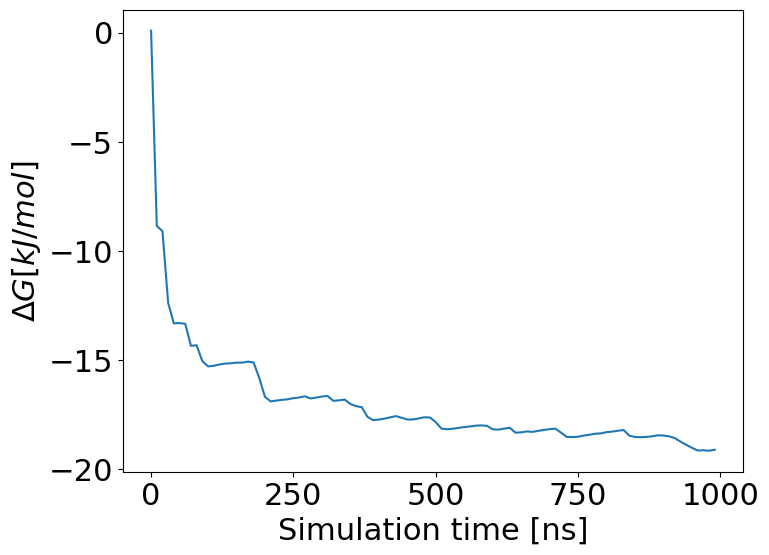

In [85]:
fig = plt.figure(figsize=(8, 6))
xlbl = range(0,1250,250)
xax = np.linspace(0,100,5)
plt.plot(DG)
plt.xticks(xax,xlbl)
plt.xlabel('Simulation time [ns]')
plt.ylabel('$\\Delta G [kJ/mol]$')
#plt.errorbar(range(len(DG)),DG,yerr=ERR)

Text(0, 0.5, '$\\Delta G [kJ/mol]$')

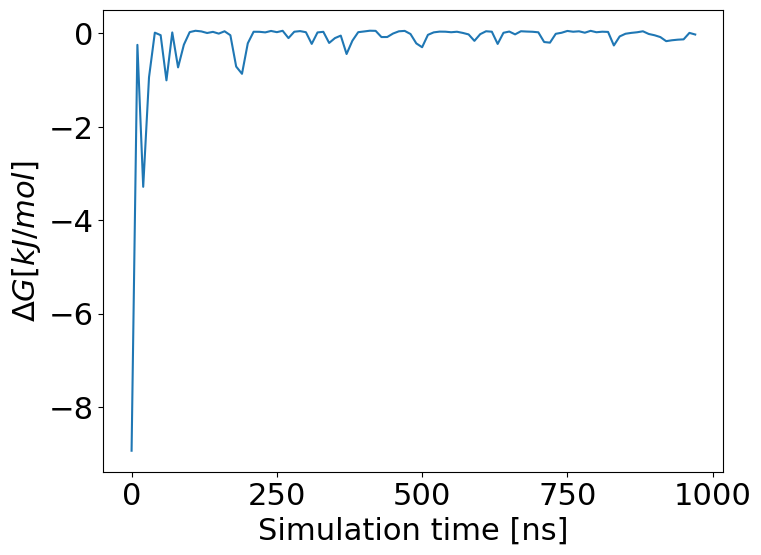

In [84]:
ddG = np.subtract(DG[1:-1],DG[0:-2])
fig = plt.figure(figsize=(8, 6))
xlbl = range(0,1250,250)
xax = np.linspace(0,100,5)
plt.plot(ddG)
plt.xticks(xax,xlbl)
plt.xlabel('Simulation time [ns]')
plt.ylabel('$\\Delta G [kJ/mol]$')



Text(0, 0.5, '$\\Delta\\Delta G [kJ/mol]$')

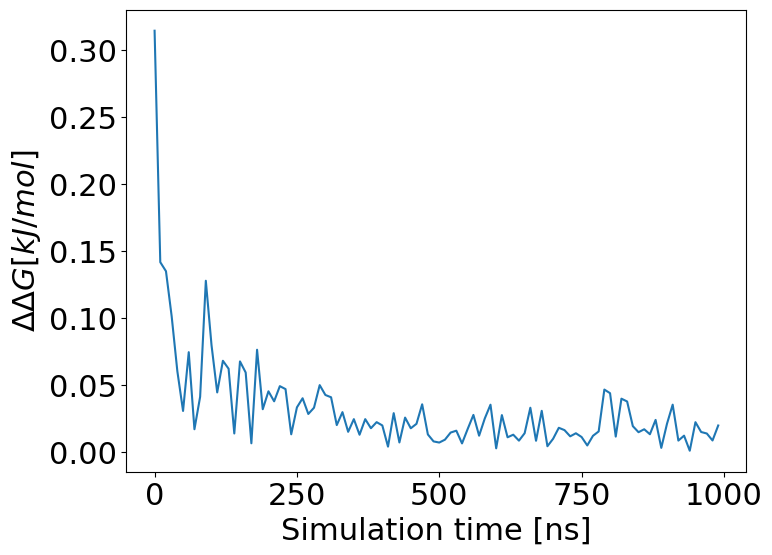

In [86]:

fig = plt.figure(figsize=(8, 6))
xlbl = range(0,1250,250)
xax = np.linspace(0,100,5)
plt.plot(ERR)
plt.xticks(xax,xlbl)
plt.xlabel('Simulation time [ns]')
plt.ylabel('$\\Delta\\Delta G [kJ/mol]$')



pfos-acd  done


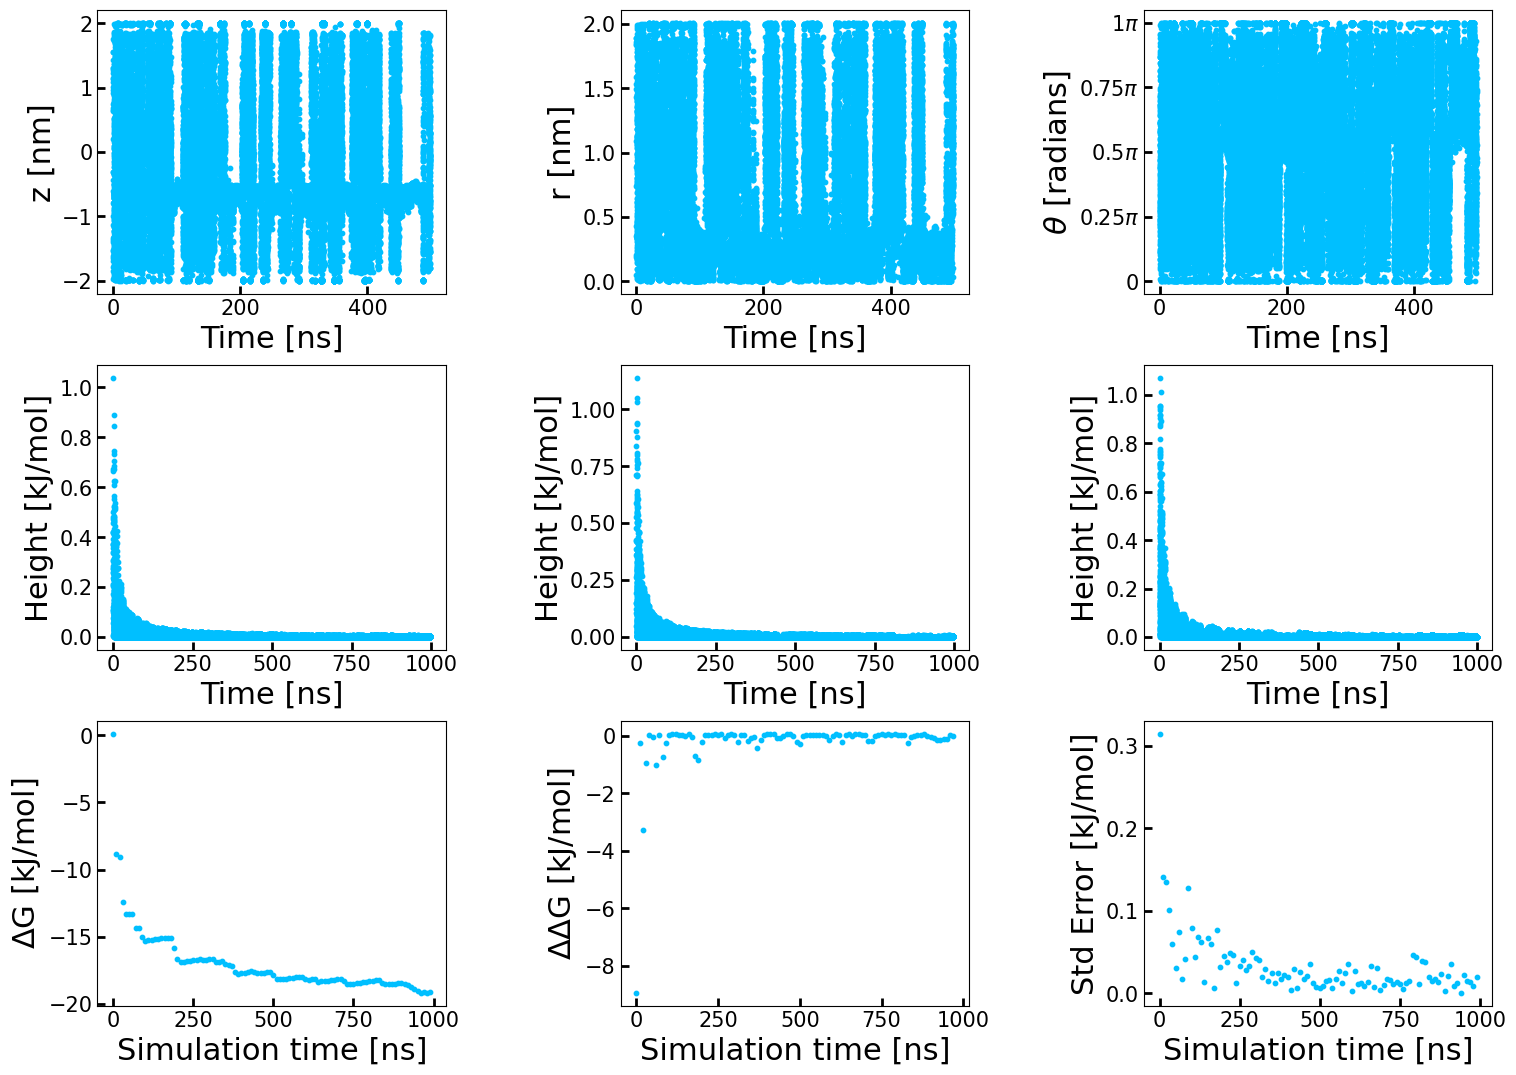

In [96]:

probe=['acd']#['sds-f-bcd','pfos-f-bcd','sds-f-bcd','pfos-f-acd','sds-f-gcd','pfos-f-gcd']
analyte = ['pfos']
for ii in probe:
    for kk in analyte:
        scratchDir = '/project2/andrewferguson/maxtopel/PFAS_TACC/system-cd/'+str(kk)+'-f-'+str(ii)+"/sphere_2nm/reweight/"
        colvar = pd.read_csv(scratchDir + "COLVAR_reweight", 
                             comment="#", delim_whitespace=True,names=["time", "angle", "r", "baxis","mag", "pr", "pz", "bias"],skip_blank_lines=True)
     
        custombias = pd.read_csv(scratchDir + "BIAS", 
                             comment="#", delim_whitespace=True, names=["time", "r", "bz", "pr", "pz", "mag", "magbias"], skip_blank_lines=True)

        hills_angle = pd.read_csv(scratchDir + "../hills_angle.out",
                            comment="#", delim_whitespace=True,  names=["time", "angle", "sigma", "height", "bf"], skip_blank_lines=True)
        hills_r = pd.read_csv(scratchDir + "../hills_r",
                            comment="#", delim_whitespace=True,  names=["time", "r", "sigma", "height", "bf"],skip_blank_lines=True)
        hills_z = pd.read_csv(scratchDir + "../hills_r.out",
                            comment="#", delim_whitespace=True, names=["time", "z", "sigma", "height", "bf"], skip_blank_lines=True)
       
        #cols = hills_angle.columns
        #for col in cols:
         #   hills_angle[col] = hills_angle[col].astype(float)
            
        time = np.multiply(np.arange(0,len(colvar.r)),0.1)
        time = time[0:499000:10]
        time_h = np.multiply(np.arange(0,999000),0.2)
        time_h = time_h[0:499000:10]
        colvar = colvar[0:499000:10]
        hills_angle = hills_angle[0:499000:10]
        hills_r = hills_r[0:499000:10]
        hills_z = hills_z[0:499000:10]
        
        #capture

        labelfont=10
        tickfont=15

        fig = plt.figure(figsize=[18,12])
        fig.tight_layout(pad=100.0)
        spec = gridspec.GridSpec(ncols=3, nrows=3)
        fig.subplots_adjust(bottom=0.05, hspace=.25, wspace=.5)

        ax = ['ax1', 'ax2', 'ax3', 'ax4', 'ax5', 'ax6', 'ax7', 'ax8', 'ax9', 'ax10']

        kT = 300*0.008314
        preFactor = 2*kT

            
        col=0
        row=0
        rgaxis=['x', 'y', 'z']

        pc=0
        ax[pc] = fig.add_subplot(spec[row, col])
        ax[pc].tick_params(axis="x", labelsize=tickfont, direction='in', length=6, width=2, colors='black', rotation=0)
        ax[pc].tick_params(axis="y", labelsize=tickfont, direction='in', length=6, width=2, colors='black')
        ax[pc].tick_params(which='minor', direction='in', length=3, width=2)

        ax[pc].scatter(time/100, colvar.baxis, 
                       s=10, alpha=1, color='deepskyblue')
        ax[pc].set_xlabel('Time [ns]')
        ax[pc].set_ylabel('z [nm]')

        pc=1
        col=1
        ax[pc] = fig.add_subplot(spec[row, col])
        ax[pc].tick_params(axis="x", labelsize=tickfont, direction='in', length=6, width=2, colors='black', rotation=0)
        ax[pc].tick_params(axis="y", labelsize=tickfont, direction='in', length=6, width=2, colors='black')
        ax[pc].tick_params(which='minor', direction='in', length=3, width=2)

        ax[pc].scatter(time/100, colvar.r, 
                       s=10, alpha=1, color='deepskyblue')
        ax[pc].set_xlabel('Time [ns]')
        ax[pc].set_ylabel('r [nm]')


        pc=2
        row=0
        col=2
        ax[pc] = fig.add_subplot(spec[row, col])
        ax[pc].tick_params(axis="x", labelsize=tickfont, direction='in', length=6, width=2, colors='black', rotation=0)
        ax[pc].tick_params(axis="y", labelsize=tickfont, direction='in', length=6, width=2, colors='black')
        ax[pc].tick_params(which='minor', direction='in', length=3, width=2)

        ax[pc].scatter(time/100, colvar.angle, 
                       s=10, alpha=1, c='deepskyblue')
        pi = np.pi
        ax[pc].set_yticks([])
        #ax[pc].set_yticks(np.arange(0, pi + pi/4, step=(pi / 4)),  ["0", FormatStrFormatter('%g $\pi/4$'),
        #                                                            FormatStrFormatter('%g $\pi/2$'),
        #                                                            FormatStrFormatter('%g $3\pi/4$'),
        #                                                            FormatStrFormatter('%g $\pi$')])


        from matplotlib.ticker import FuncFormatter, MultipleLocator
        #ax.xaxis.set_major_formatter(FormatStrFormatter('%g $\pi$'))
        ax[pc].yaxis.set_major_formatter(FuncFormatter(
           lambda val,pos: '{:g}$\pi$'.format(val/np.pi) if val !=0 else '0'
        ))
        ax[pc].yaxis.set_major_locator(MultipleLocator(base=np.pi/4))

        #ax[pc].set_yticks(np.arange(0, 1 + 1/4, step=(1 / 4)))                                                           #"π/4", "π/2", "3π/4", "π"])
        #from matplotlib.ticker import FormatStrFormatter
        #ax[pc].yaxis.set_major_formatter(FormatStrFormatter('%g $\pi$'))
        ax[pc].set_xlabel('Time [ns]')
        ax[pc].set_ylabel('$\\theta$ [radians]')

        
        pc=3
        row=1
        col=0
        ax[pc] = fig.add_subplot(spec[row, col])
        ax[pc].tick_params(axis="x", labelsize=tickfont, direction='in', length=6, width=2, colors='black', rotation=0)
        ax[pc].tick_params(axis="y", labelsize=tickfont, direction='in', length=6, width=2, colors='black')
        ax[pc].tick_params(which='minor', direction='in', length=3, width=2)

        ax[pc].scatter(time_h[0:len(hills_r.r)]/100, hills_r.height, 
                       s=10, alpha=1, color='deepskyblue')
        ax[pc].set_xlabel('Time [ns]')
        ax[pc].set_ylabel('Height [kJ/mol]')



        pc=4
        row=1
        col=1
        ax[pc] = fig.add_subplot(spec[row, col])
        ax[pc].tick_params(axis="x", labelsize=tickfont, direction='in', length=6, width=2, colors='black', rotation=0)
        ax[pc].tick_params(axis="y", labelsize=tickfont, direction='in', length=6, width=2, colors='black')
        ax[pc].tick_params(which='minor', direction='in', length=3, width=2)

        ax[pc].scatter(time_h[0:len(hills_angle.height)]/100, hills_angle.height, 
                       s=10, alpha=1, color='deepskyblue')
        ax[pc].set_xlabel('Time [ns]')
        ax[pc].set_ylabel('Height [kJ/mol]')


        pc=5
        row=1
        col=2
        ax[pc] = fig.add_subplot(spec[row, col])
        ax[pc].tick_params(axis="x", labelsize=tickfont, direction='in', length=6, width=2, colors='black', rotation=0)

        ax[pc].tick_params(axis="y", labelsize=tickfont, direction='in', length=6, width=2, colors='black')
        ax[pc].tick_params(which='minor', direction='in', length=3, width=2)

        ax[pc].scatter(time_h[0:len(hills_z.height)]/100, hills_z.height, 
                       s=10, alpha=1, color='deepskyblue')
        ax[pc].set_xlabel('Time [ns]')
        ax[pc].set_ylabel('Height [kJ/mol]')

        

        xlbl = range(0,1250,250)
        xax = np.linspace(0,100,5)      

        pc=6
        row=2
        col=0
        ax[pc] = fig.add_subplot(spec[row, col])
        ax[pc].tick_params(axis="x", labelsize=tickfont, direction='in', length=6, width=2, colors='black', rotation=0)

        ax[pc].tick_params(axis="y", labelsize=tickfont, direction='in', length=6, width=2, colors='black')
        ax[pc].tick_params(which='minor', direction='in', length=3, width=2)

        ax[pc].scatter(range(len(DG)), DG, 
                       s=10, alpha=1, color='deepskyblue')
        ax[pc].set_xlabel('Simulation time [ns]')
        ax[pc].set_ylabel('$\\Delta$G [kJ/mol]')
        ax[pc].set_xticks(xax,xlbl)

        pc=7
        row=2
        col=1
        ax[pc] = fig.add_subplot(spec[row, col])
        ax[pc].tick_params(axis="x", labelsize=tickfont, direction='in', length=6, width=2, colors='black', rotation=0)

        ax[pc].tick_params(axis="y", labelsize=tickfont, direction='in', length=6, width=2, colors='black')
        ax[pc].tick_params(which='minor', direction='in', length=3, width=2)

        ax[pc].scatter(range(len(ddG)), ddG, 
                       s=10, alpha=1, color='deepskyblue')
        ax[pc].set_xlabel('Simulation time [ns]')
        ax[pc].set_ylabel('$\\Delta\\Delta$G [kJ/mol]')
        ax[pc].set_xticks(xax,xlbl)

        pc=8
        row=2
        col=2
        ax[pc] = fig.add_subplot(spec[row, col])
        ax[pc].tick_params(axis="x", labelsize=tickfont, direction='in', length=6, width=2, colors='black', rotation=0)

        ax[pc].tick_params(axis="y", labelsize=tickfont, direction='in', length=6, width=2, colors='black')
        ax[pc].tick_params(which='minor', direction='in', length=3, width=2)

        ax[pc].scatter(range(len(ERR)), ERR, 
                       s=10, alpha=1, color='deepskyblue')
        ax[pc].set_xlabel('Simulation time [ns]')
        ax[pc].set_ylabel('Std Error [kJ/mol]')
        ax[pc].set_xticks(xax,xlbl)



        figName = 'Fig-'+str(kk)+'-'+str(ii)+'.png'
        print(str(kk)+'-'+str(ii), ' done')
        plt.savefig(figName, bbox_inches = "tight", dpi=200)

(-0.051829786937505215, 0.01)

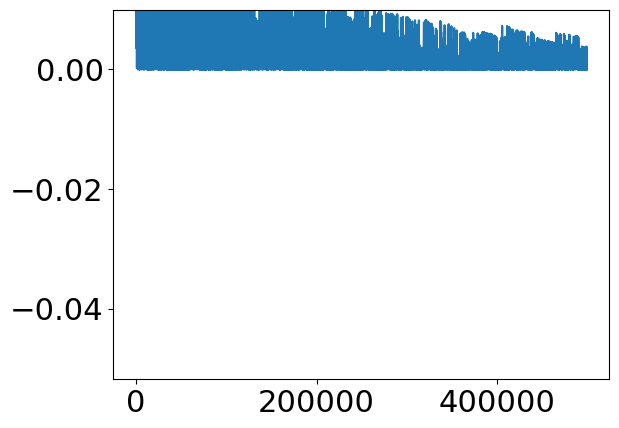

In [103]:
plt.plot(hills_r.height[0:100000])
plt.ylim(ymax=0.01)

# SANDBOX


In [24]:
#some functions

def const_pts(xr,xz):
    #construct pts
    cords = []#np.zeros((len(xr),len(xz)))
    XR =[]
    XZ = []
    for i in range(len(xr)):
        for j in range(len(xz)):
            cords.append([xz[j],xr[i]])
            XR.append(xr[i])
            XZ.append(xz[i])
    DAT = interp(cords)
    iii = 0
    DATA =np.zeros((len(xr),len(xz)))
    for i in range(len(xr)):
        for j in range(len(xz)):
            DATA[i,j] = DAT[iii]
            iii+=1
    return XR,XZ,DATA,DAT

def gaussxw(N):

    # Initial approximation to roots of the Legendre polynomial
    a = linspace(3,4*N-1,N)/(4*N+2)
    x = cos(pi*a+1/(8*N*N*tan(a)))

    # Find roots using Newton's method
    epsilon = 1e-15
    delta = 1.0
    while delta>epsilon:
        p0 = ones(N,float)
        p1 = copy(x)
        for k in range(1,N):
            p0,p1 = p1,((2*k+1)*x*p1-k*p0)/(k+1)
        dp = (N+1)*(p0-x*p1)/(1-x*x)
        dx = p1/dp
        x -= dx
        delta = max(abs(dx))

    # Calculate the weights
    w = 2*(N+1)*(N+1)/(N*N*(1-x*x)*dp*dp)

    return x,w

def gaussxwab(N,a,b):
    x,w = gaussxw(N)
    return 0.5*(b-a)*x+0.5*(b+a),0.5*(b-a)*w

def barit(title,sub):
# Plot scatter here
    plt.figure(figsize=(15,10))
    lbl = ['acd-pfos','acd-tcaa','bcd-pfos','bcd-tcaa','gcd-pfos','gcd-tcaa']
    plt.bar(lbl, avgFE)
    plt.errorbar(lbl, avgFE, yerr=sdFE, fmt="o", color="r")
    plt.xticks(ha='right', rotation=55, fontsize=20)
    plt.yticks(ha='right', fontsize=20)
    plt.xlabel('System', fontsize=25)
    plt.ylabel('Free Energy (kJ/mol)', fontsize=25)
    plt.title(title, fontsize=25)
    plt.savefig('Bar_'+sub+'.png')
    plt.show()
    plt.close()
    return

def correct():
    #STD vol concentration
    avgn =6.0221408e+23
    kb=1.380649e-23
    T=300  
    vstd = 1.66e-27
    vfun = (4/3*np.pi*(2e-9)**3)#*1e-27
    corrstd = kb*T*np.log((vstd/vfun)**(1/3))
    CORR = corrstd*1e-3*avgn
    return CORR

def simps(f,a,b,N,dz):
    if N % 2 == 1:
        raise ValueError("N must be an even integer.")
    dx = dz #(b-a)/N
    x = np.linspace(a,b,N+1)
    y = f[a:b]
    S = dx/3 * np.sum(y[0:-1:2] + 4*y[1::2] + y[2::2])
    return S
from scipy.integrate import simpson
#generate FES
from numpy import inf, nan

def genFES(probe, analyte,blocks,dimz,dimr):
    
        FEDF = []
        avgminima = []
        sdminima = []
        mini = []
        feDf_t = []
        
        colvarFile = '/project2/andrewferguson/maxtopel/PFAS_TACC/system-cd/reweights/'+str(analyte)+'-'+str(probe)+"/COLVAR_reweight" #simDir + systemDir + colvarFileName
        colvarData = pd.read_csv(colvarFile, comment="#", delim_whitespace=True,names=["time", "angle", "r", "baxis","mag", "pr", "pz", "bias"],skip_blank_lines=True)
        # discard initial few frames [frames where free energy is still being mapped]
       # if probe=='bcd' and analyte=='pfos':
        print('datalen', len(colvarData))
    
       # colvarD = colvarData[s:d].sample(frac = 1)  #colvarData[s:d])
        if  analyte=='pfos': #probe=='acd' or probe=='gcd' and
            s = 50000
            d = 500001
            colvarD = colvarData[s:d].sample(frac = 1)
        #np.random.shuffle(colvarData[s:d])
        else:
            s = 100000
            d = 1000000
            colvarD = colvarData[s:d:2].sample(frac = 1)
                
        jmp = len(colvarD)//blocks
        for jj in range(blocks):
            CORR = correct()
            colvarData = colvarD[jmp*jj:jmp*(jj+1)] 

        ############################################################################################
            #make a 3D heat map
            bias = colvarData['bias']
            rr = colvarData['r']
            zz = colvarData['baxis']

            kb = 8.31446261815324*0.001 #kJ/molK
            temperature = 300
            kbt = kb*temperature  #kJ/mol
            # calculate weights of each frame in colvarData - CHECK THIS APPROACH (SUMMING THE BIASES)
            weights = np.exp( (bias) /kbt)
            xedges = np.linspace(rlima,rlimb,dimr+1)
            yedges = np.linspace(zlima,zlimb,dimz+1)
            # get unbiased probabilities
            fe, xedges,yedges = np.histogram2d(rr,zz,range=[[rlima,rlimb],[zlima,zlimb]],bins=(xedges,yedges),weights=weights,density=True)
            # free energy
            feDf = -kbt*np.log(fe)
            #free energy correction
            feDf -= CORR 
            #make negative
            feDf -= np.nanmax(feDf[feDf!=np.inf])
            # set all infs to zero for fit
            feDf[feDf == -inf] = 0
            feDf[feDf == inf] = 0
            mini.append(np.amin(feDf))
            FEDF.append(feDf)

        avgminima.append(np.mean(np.array(mini)))
        sdminima.append(np.std(np.array(mini)))

        
        return FEDF, avgminima, sdminima

def Int1(probe, analyte,dimr,dimz,feDf,wr,xr,wz,xz,blocks):
    #read in probe, analyte, number of r and z grid 
    avgFE,sdFE = [],[]
    fe_min =-1000
    C0 = 1/(1661*1e-3)
    avgkb,sdkb = [],[]
    iii = 0
    kb = 8.31446261815324*0.001 #kJ/molK
    temperature = 300
    kbt = kb*temperature 
    for ii in probe:
        for kk in analyte:

            disco,kbv = [],[]

            for jj in range(blocks):
                disc,kbp = 0,0

                for i in range(dimr):
                    for j in range(dimz):
                        disc -= wr[j]*xr[j]*wz[j]*feDf[i,j]                #*simps(fx,a,b-1,space,dz)       #*delt#boundReg[i,j]*delt
                        kbp += wr[j]*xr[j]*wz[j]*np.exp(-feDf[i,j]/kbt)    #*np.exp(-fx/kbt),a,b-1,space,dz)#wr[j]*xr[j]*delt*np.exp(-feDf[i,j]/kbt)#*delt boundReg
                
                kbv.append(kbp*2*np.pi*C0)    
                disco.append(disc*2*np.pi)

    avgFE.append(np.mean(disco))
    sdFE.append(np.std(disco))
    avgkb.append(np.mean(kbv))
    sdkb.append(np.std(kbv))

    iii +=1

    return avgFE,sdFE,avgkb,sdkb

def Int2(probe, analyte,dimr,dimz,feDf,wr,xr,wz,xz,blocks):
    #read in probe, analyte, number of r and z grid 
    avgFE,sdFE = [],[]
    fe_min =-1000
    C0 = 1/(1661*1e-3)
    avgkb,sdkb = [],[]
    iii = 0
    kb = 8.31446261815324*0.001 #kJ/molK
    temperature = 300
    kbt = kb*temperature 
    for ii in probe:
        for kk in analyte:

            disco,kbv = [],[]

            for jj in range(blocks):
                disc,kbp = 0,0
                R[i] 
                for i in range(dimr):
                    for j in range(dimz):
                        disc +=  R[i]*feDf[i,j]*delt# simps(fx,a,b-1,space,dz)       #*delt #boundReg[i,j]*delt #wr[j]*xr[j]*wz[j]*feDf[i,j]               
                        kbp += R[i]*np.exp(-feDf[i,j]/kbt)*delt #wr[j]*xr[j]*wz[j]*np.exp(-feDf[i,j]/kbt)    #*np.exp(-fx/kbt),a,b-1,space,dz)#wr[j]*xr[j]*delt*np.exp(-feDf[i,j]/kbt)#*delt boundReg
                
                kbv.append(kbp*2*np.pi*C0)    
                disco.append(disc*2*np.pi)

    avgFE.append(np.mean(disco))
    sdFE.append(np.std(disco))
    avgkb.append(np.mean(kbv))
    sdkb.append(np.std(kbv))

    iii +=1

    return avgFE,sdFE,avgkb,sdkb


import matplotlib.gridspec as gridspec

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example data (you can replace this with your own values)
values = np.array([1, 2, 3, 4, 5])
std_error_positive = np.array([0.2, 0.3, 0.25, 0.18, 0.3])
std_error_negative = np.array([0.15, 0.25, 0.2, 0.1, 0.25])

# Plotting the main line
plt.plot(values, label='Values')

# Plotting positive standard error
plt.plot(values + std_error_positive, linestyle='--', color='gray', label='Positive SE')

# Plotting negative standard error
plt.plot(values - std_error_negative, linestyle='--', color='gray', label='Negative SE')

# Styling
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Values with Standard Errors')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Example data (you can replace this with your own values)
values = np.array([1, 2, 3, 4, 5])
std_error_positive = np.array([0.2, 0.3, 0.25, 0.18, 0.3])
std_error_negative = np.array([0.15, 0.25, 0.2, 0.1, 0.25])

# Seaborn style
sns.set_style("darkgrid")

# Plotting the main line
plt.plot(values, label='Values', linestyle='-', marker='o', markersize=5)

# Plotting positive standard error
plt.plot(values + std_error_positive, linestyle='--', color='gray', label='Positive SE', alpha=0.7)

# Plotting negative standard error
plt.plot(values - std_error_negative, linestyle='--', color='gray', label='Negative SE', alpha=0.7)

# Styling
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Values with Standard Errors')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
C0 = 1/(1661*1e-3)
kb = 8.31446261815324*0.001 #kJ/molK
temperature = 300
kbt = kb*temperature  #kJ/mol
probe= ['acd','bcd','gcd']
analyte = ['TCAA','pfos']
#choose number of blocks
blocks = 1 #3
cutoff1 = np.sqrt(3.5)
cutoff2 = 2

for dimr in [250]:
    for cutoff in [1]:
        dimz = dimr
        pmf_probe_analyte_zero_ref_boundary = {} # collect pmfs
        pmf_probe_analyte_zero_ref_global_minima = {} # collect pmfs

        for ii in probe:
            for kk in analyte:

                pmf_probe_analyte_zero_ref_global_minima[ii+'_'+kk] = {}
                pmf_probe_analyte_zero_ref_boundary[ii+'_'+kk]  = {}

                #create holders
                fep = []
                avgFE,sdFE = [],[]
                avgkb,sdkb = [],[]
                #load data 
                colvarFile = '/project2/andrewferguson/maxtopel/PFAS_TACC/system-cd/reweights/'+kk+'-'+ii+"/COLVAR_reweight" #simDir + systemDir + colvarFileName
                #print(colvarFile)
                colvarData = pd.read_csv(colvarFile, comment="#", 
                                         delim_whitespace=True,names=["time", "angle", "r", 
                                                                      "baxis","mag", "pr", "pz", "bias"],
                                         skip_blank_lines=True)

                # discard initial few frames [frames where free energy is still being mapped]
                # subsample and randomize
                if kk=='pfos': #probe=='acd' or probe=='gcd' and analyte=='pfos':
                    s = 50000
                    d = -1 #500001
                    colvarD = colvarData[s:d].sample(frac = 1)
                else:
                    s = 100000
                    d = -1 #1000000
                    colvarD = colvarData[s:d:2].sample(frac = 1)        
                jmp = len(colvarD)//blocks

                print(ii,kk, len(colvarD), blocks, jmp)
                #\print(colvarD)
                for jj in range(blocks):
                    colvarData_init = colvarD[jmp*jj:jmp*(jj+1)] 
                    print(f'Before filter: {colvarData_init.shape}')


                    #colvarData = colvarData_init[(colvarData_init['r']**2 + colvarData_init['baxis']**2 < 3.5)]

                    colvarData_2 = colvarData_init[(colvarData_init['r'] < cutoff1)]
                    colvarData_3 = colvarData_2[(colvarData_2['baxis'] < cutoff1)]
                    colvarData = colvarData_3[(colvarData_3['baxis'] >= -cutoff1)]
                    
                    #colvarData = colvarData_init

                    print(f'After filter (<3. spherical cut): {colvarData.shape}')

                    ############################################################################################################
                    #make a 2D heat map
                    bias = colvarData['bias'] 
                    r = colvarData['r']
                    z = colvarData['baxis']

                    # calculate weights of each frame in colvarData - CHECK THIS APPROACH (SUMMING THE BIASES)
                    weights = np.exp((bias) /kbt)        
                    xedges = np.linspace(0,cutoff1,dimr)
                    yedges = np.linspace(-cutoff1,cutoff1,dimz)
                    dr,dz = abs(xedges[0]-xedges[1]),abs(yedges[0]-yedges[1])
                    # get unbiased probabilities
                    fe, xedges,yedges = np.histogram2d(r,z,range=[[0,cutoff1],[-cutoff1,cutoff1]],
                                                       bins=(xedges,yedges),
                                                       weights=weights,density=True)


                    # get unbiased probabilities -- 1 D along r, z
                    fe_r, xedges_r = np.histogram(r, range=[0,cutoff1], bins=xedges, weights=weights,density=True)
                    fe_z, xedges_z = np.histogram(z, range=[-cutoff1,cutoff1], bins=yedges, weights=weights,density=True)
                    fe_r = fe_r.T
                    fe_z = fe_z.T
                    fe_r = -kbt*np.log(fe_r)
                    fe_z = -kbt*np.log(fe_z)

                    fe = fe.T
                    feDf = -kbt*np.log(fe) # Compute free energy


                   
                   
                   # print(feDf)

                    feDf_zero_ref_global_minima = feDf - feDf.min() # UNCOMMENT THIS FOR SETTING GLOBAL FREE ENERGY MINIMA AS ZERO

                    _block_data_global_minima = {'fe': feDf_zero_ref_global_minima, 
                                                 'xedges': xedges, 'yedges': yedges}

                    pmf_probe_analyte_zero_ref_global_minima[ii+'_'+kk]['block'+str(jj)] = _block_data_global_minima

                    # Find values of free energy on the boundary of the surface
                    avg_fe_beyond_cutoff=[]
                    for ki in range(xedges.shape[0]-1):
                        for kj in range(yedges.shape[0]-1):
        #                     if xedges[ki]**2 + np.abs(yedges[kj])**2 > 1.25: # 2.0:
                            if np.isnan(feDf[kj,ki]) or np.isinf(feDf[kj,ki]):
                                continue

                            #if 1.48 <= xedges[ki] < 1.5 and -1.48**2 <= yedges[kj]**2 < 1.5**2:
                            if xedges[ki] > cutoff or yedges[kj] < -cutoff or yedges[kj] > cutoff:

                                avg_fe_beyond_cutoff.append(feDf[kj,ki])


############################################################################
                    # Set free energy on the boundary to zero
        #             collect_fe_k = np.array(collect_fe_k)
        #             collect_fe_k_max = collect_fe_k.max()
                    #print(collect_fe_k.shape, collect_fe_k.min(), collect_fe_k.max())

                    avg_fe_beyond_cutoff = np.array(avg_fe_beyond_cutoff)

                    print(f'avg:{avg_fe_beyond_cutoff.mean()}, sd:{np.std(avg_fe_beyond_cutoff)},max:{avg_fe_beyond_cutoff.max()}, min:{avg_fe_beyond_cutoff.min()}')

                    #feDf_zero_ref_boundary = feDf - feDf.max() #collect_fe_k_max # UNCOMMENT THIS FOR SETTING BOUNDARY FREE ENERGY TO ZERO
                    feDf_zero_ref_boundary = feDf - avg_fe_beyond_cutoff.mean() #collect_fe_k_max # UNCOMMENT THIS FOR SETTING BOUNDARY FREE ENERGY TO ZERO
                    fe_r = fe_r - avg_fe_beyond_cutoff.mean()
                    fe_z = fe_z - avg_fe_beyond_cutoff.mean()

                    print(xedges.min(), xedges.max(), yedges.min(), yedges.max())

                    _block_data_boundary = {'fe': feDf_zero_ref_boundary,
                                            'xedges': xedges,
                                            'yedges': yedges,
                                            'fe_r': fe_r,
                                             'xedges_r':xedges_r,
                                            'fe_z': fe_z,
                                             'xedges_z':xedges_z}
                                            #'fe_points_on_boundary': fe_points_on_boundary}

                    pmf_probe_analyte_zero_ref_boundary[ii+'_'+kk]['block'+str(jj)] = _block_data_boundary

                    print(ii, kk, jj)
                    print(dimr,dimz,cutoff)


In [ ]:
C0 = 1/(1661*1e-3)
kb = 8.31446261815324*0.001 #kJ/molK
temperature = 300
kbt = kb*temperature  #kJ/mol
probe= ['acd','bcd','gcd']
analyte = ['TCAA','pfos']
#choose number of blocks
blocks = 1 #3
cutoff1 = np.sqrt(3.5)
cutoff2 = 2

for dimr in [250]:
    for cutoff in [1]:
        dimz = dimr
        pmf_probe_analyte_zero_ref_boundary = {} # collect pmfs
        pmf_probe_analyte_zero_ref_global_minima = {} # collect pmfs

        
        for kk in analyte:
            for ii in probe:

                pmf_probe_analyte_zero_ref_global_minima[ii+'_'+kk] = {}
                pmf_probe_analyte_zero_ref_boundary[ii+'_'+kk]  = {}

                #create holders
                fep = []
                avgFE,sdFE = [],[]
                avgkb,sdkb = [],[]
                #load data 
                colvarFile = '/project2/andrewferguson/maxtopel/PFAS_TACC/system-cd/reweights/'+kk+'-'+ii+"/COLVAR_reweight" #simDir + systemDir + colvarFileName
                #print(colvarFile)
                colvarData = pd.read_csv(colvarFile, comment="#", 
                                         delim_whitespace=True,names=["time", "angle", "r", 
                                                                      "baxis","mag", "pr", "pz", "bias"],
                                         skip_blank_lines=True)

                # discard initial few frames [frames where free energy is still being mapped]
                # subsample and randomize
                if kk=='pfos': #probe=='acd' or probe=='gcd' and analyte=='pfos':
                    s = 50000
                    d = -1 #500001
                    colvarD = colvarData[s:d].sample(frac = 1)
                else:
                    s = 100000
                    d = -1 #1000000
                    colvarD = colvarData[s:d:2].sample(frac = 1)        
                jmp = len(colvarD)//blocks

                print(ii,kk, len(colvarD), blocks, jmp)
                #\print(colvarD)
                for jj in range(blocks):
                    colvarData_init = colvarD[jmp*jj:jmp*(jj+1)] 
                    print(f'Before filter: {colvarData_init.shape}')


                    #colvarData = colvarData_init[(colvarData_init['r']**2 + colvarData_init['baxis']**2 < 3.5)]

                    #colvarData_2 = colvarData_init[(colvarData_init['r'] < cutoff1)]
                    #colvarData_3 = colvarData_2[(colvarData_2['baxis'] < cutoff1)]
                    #colvarData = colvarData_3[(colvarData_3['baxis'] >= -cutoff1)]
                    
                    #colvarData = colvarData_init

                    print(f'After filter (<3. spherical cut): {colvarData.shape}')

                    ############################################################################################################
                    #make a 2D heat map
                    bias = colvarData_init['bias'] 
                    r = colvarData_init['r']
                    z = colvarData_init['baxis']

                    # calculate weights of each frame in colvarData - CHECK THIS APPROACH (SUMMING THE BIASES)
                    weights = np.exp((bias) /kbt)        
                    xedges = np.linspace(0,cutoff2,dimr)
                    yedges = np.linspace(-cutoff2,cutoff2,dimz)
                    dr,dz = abs(xedges[0]-xedges[1]),abs(yedges[0]-yedges[1])
                    # get unbiased probabilities
                    fe, xedges,yedges = np.histogram2d(r,z,range=[[0,cutoff2],[-cutoff2,cutoff2]],
                                                       bins=(xedges,yedges),
                                                       weights=weights,density=True)


                    # get unbiased probabilities -- 1 D along r, z
                    fe_r, xedges_r = np.histogram(r, range=[0,cutoff1], bins=xedges, weights=weights,density=True)
                    fe_z, xedges_z = np.histogram(z, range=[-cutoff1,cutoff1], bins=yedges, weights=weights,density=True)
                    fe_r = fe_r.T
                    fe_z = fe_z.T
                    fe_r = -kbt*np.log(fe_r)
                    fe_z = -kbt*np.log(fe_z)

                    fe = fe.T
                    feDf = -kbt*np.log(fe) # Compute free energy
                   # print(feDf)

                    feDf_zero_ref_global_minima = feDf - feDf.min() # UNCOMMENT THIS FOR SETTING GLOBAL FREE ENERGY MINIMA AS ZERO

                    _block_data_global_minima = {'fe': feDf_zero_ref_global_minima, 
                                                 'xedges': xedges, 'yedges': yedges}

                    pmf_probe_analyte_zero_ref_global_minima[ii+'_'+kk]['block'+str(jj)] = _block_data_global_minima

                    # Find values of free energy on the boundary of the surface
                    avg_fe_beyond_cutoff=[]
                    for ki in range(xedges.shape[0]-1):
                        for kj in range(yedges.shape[0]-1):
        #                     if xedges[ki]**2 + np.abs(yedges[kj])**2 > 1.25: # 2.0:
                            if np.isnan(feDf[kj,ki]) or np.isinf(feDf[kj,ki]):
                                continue

                            #cutoffs 
                            if xedges[ki] > cutoff or yedges[kj] < -cutoff or yedges[kj] > cutoff and xedges[ki] < cutoff1 and yedges[kj] < cutoff1 and yedges[kj] > cutoff1:

                                avg_fe_beyond_cutoff.append(feDf[kj,ki])


                    avg_fe_beyond_cutoff = np.array(avg_fe_beyond_cutoff)

                    print(f'avg:{avg_fe_beyond_cutoff.mean()}, sd:{np.std(avg_fe_beyond_cutoff)},max:{avg_fe_beyond_cutoff.max()}, min:{avg_fe_beyond_cutoff.min()}')

                    #feDf_zero_ref_boundary = feDf - feDf.max() #collect_fe_k_max # UNCOMMENT THIS FOR SETTING BOUNDARY FREE ENERGY TO ZERO
                    feDf_zero_ref_boundary = feDf - avg_fe_beyond_cutoff.mean() #collect_fe_k_max # UNCOMMENT THIS FOR SETTING BOUNDARY FREE ENERGY TO ZERO
                    fe_r = fe_r - avg_fe_beyond_cutoff.mean()
                    fe_z = fe_z - avg_fe_beyond_cutoff.mean()

                    print(xedges.min(), xedges.max(), yedges.min(), yedges.max())

                    _block_data_boundary = {'fe': feDf_zero_ref_boundary,
                                            'xedges': xedges,
                                            'yedges': yedges,
                                            'fe_r': fe_r,
                                             'xedges_r':xedges_r,
                                            'fe_z': fe_z,
                                             'xedges_z':xedges_z}
                                            #'fe_points_on_boundary': fe_points_on_boundary}

                    pmf_probe_analyte_zero_ref_boundary[ii+'_'+kk]['block'+str(jj)] = _block_data_boundary

                    print(ii, kk, jj)
                    print(dimr,dimz,cutoff)


In [ ]:
V0 = 1661*1e-3
Vf = 32*np.pi/3
CP = V0/Vf
kb = 8.31446261815324*0.001 #kJ/molK
temperature = 300
kbt = kb*temperature  #kJ/mol
probe= ['acd','bcd','gcd']
analyte = ['TCAA','pfos']
#choose number of blocks
blocks = 3
#define dimensions in r and z directions
#dimz = 100
#dimr = 100

pmf_probe_analyte_zero_ref_boundary = {} # collect pmfs
pmf_probe_analyte_zero_ref_global_minima = {} # collect pmfs
dimvec = [50,100,250,500]
cutvec = [0.6,0.8,1,1.2,1.4]

deltag_kb_probe_analyte_block = {}
cutoff1 = np.sqrt(3.5)
overmat = []
iii = 0
for ii in probe:
    for kk in analyte:
       
                dimz = 200 #dimvec[ll]
                cutoff = 1 #cutvec[mm]
                dimr = dimz
                pmf_probe_analyte_zero_ref_global_minima[ii+'_'+kk] = {}
                pmf_probe_analyte_zero_ref_boundary[ii+'_'+kk]  = {}

                deltag_kb_probe_analyte_block[ii+'_'+kk] = {}

                #create holders
                fep = []
                avgFE,sdFE = [],[]
                avgkb,sdkb = [],[]
                #load data 
                colvarFile = '/project2/andrewferguson/maxtopel/PFAS_TACC/system-cd/reweights/'+kk+'-'+ii+"/COLVAR_reweight" #simDir + systemDir + colvarFileName

                colvarData = pd.read_csv(colvarFile, comment="#", 
                                         delim_whitespace=True,names=["time", "angle", "r", 
                                                                      "baxis","mag", "pr", "pz", "bias"],
                                         skip_blank_lines=True)

                # discard initial few frames [frames where free energy is still being mapped]
                # subsample and randomize
                if kk=='pfos': 
                    s = 50000
                    d = 500001
                    colvarD = colvarData[s:d].sample(frac = 1)
                else:
                    s = 100000
                    d = 1000000
                    colvarD = colvarData[s:d:2].sample(frac = 1)        
                jmp = len(colvarD)//blocks


                for jj in range(blocks): 
                    colvarData_init = colvarD[jmp*jj:jmp*(jj+1)] 
                    print(jmp*jj,jmp*(jj+1))


                    colvarData_2 = colvarData_init[(colvarData_init['r'] < cutoff1)]
                    colvarData_3 = colvarData_2[(colvarData_2['baxis'] < cutoff1)]
                    colvarData = colvarData_3[(colvarData_3['baxis'] >= -cutoff1)]
                    ############################################################################################################
                    #make a 2D heat map
                    bias = colvarData['bias'] 
                    r = colvarData['r']
                    z = colvarData['baxis']
                    
                    # calculate weights of each frame in colvarData - CHECK THIS APPROACH (SUMMING THE BIASES)
                    weights = np.exp((bias) /kbt)        
                    xedges = np.linspace(0,cutoff1,dimr)
                    yedges = np.linspace(-cutoff1,cutoff1,dimz)
                    #print(xedges,yedges)
                    dr,dz = abs(xedges[0]-xedges[1]),abs(yedges[0]-yedges[1])
                    # get unbiased probabilities
                    fe, xedges,yedges = np.histogram2d(r,z,range=[[0,cutoff1],[-cutoff1,cutoff1]],
                                                       bins=(xedges,yedges),
                                                       weights=weights,density=True)

                    fe = fe.T
                    feDf = -kbt*np.log(fe) # Compute free energy
                    ######## correction
                    #correction
                    for ki in range(xedges.shape[0]-1):
                        for kj in range(yedges.shape[0]-1):
        #                     if xedges[ki]**2 + np.abs(yedges[kj])**2 > 1.25: # 2.0:
                   
                            if np.isnan(feDf[kj,ki]) or np.isinf(feDf[kj,ki]):
                                continue
    
                            s = np.sqrt(xedges[ki]**2+yedges[kj]**2)
                            feDf[ki,kj] += preFactor*np.log(s)
####################################

            
                    # Find values of free energy on the boundary of the surface
                    avg_fe_beyond_cutoff=[]
                    for ki in range(xedges.shape[0]-1):
                        for kj in range(yedges.shape[0]-1):

                            if np.isnan(feDf[kj,ki]) or np.isinf(feDf[kj,ki]):
                                continue
                           # print(bool(xedges[ki]>0.8),ki, xedges[ki])
                            #if 1.48 <= xedges[ki] < 1.5 and -1.48**2 <= yedges[kj]**2 < 1.5**2:
                            if xedges[ki] > cutoff or yedges[kj] < -cutoff or yedges[kj] > cutoff:
                                avg_fe_beyond_cutoff.append(feDf[kj,ki])
                        



                    avg_fe_beyond_cutoff = np.array(avg_fe_beyond_cutoff)
                 #   print(avg_fe_beyond_cutoff,len(avg_fe_beyond_cutoff))
                    cutmean = avg_fe_beyond_cutoff.mean()
                    cutstd = avg_fe_beyond_cutoff.std()
                    feDf_zero_ref_boundary = feDf - avg_fe_beyond_cutoff.mean() #collect_fe_k_max # UNCOMMENT THIS FOR SETTING BOUNDARY FREE ENERGY TO ZERO
                    _block_data_boundary = {'fe': feDf_zero_ref_boundary,
                                            'xedges': xedges,
                                            'yedges': yedges}

                    pmf_probe_analyte_zero_ref_boundary[ii+'_'+kk]['block'+str(jj)] = _block_data_boundary

                    selected_fe = pmf_probe_analyte_zero_ref_boundary[ii+'_'+kk]['block'+str(jj)]['fe']


                    ##Compute deltaG and kb
                    ##Also visualize the cutoff area for bounded region
                    print('Computing free energies ...')
                    dgh=0
                    dgh_unbound = 0
                    #simulation_volume = 0 # term 1/C in Kb. 1/(simulation concentration)

                    for ki in range(xedges.shape[0]-1):
                        for kj in range(yedges.shape[0]-1):

                           
                            # integrate below the upper cutoff of the above region.
                            if xedges[ki] < cutoff and (yedges[kj] > -cutoff and yedges[kj] < cutoff):
                
                                # convert selected_fe to probability (redundant step; done previously for visualization)
                                #dgh += np.exp(-selected_fe/kbt)[kj,ki]*dr*dz*xedges[ki]
                                dgh += np.exp(-selected_fe[kj,ki]/kbt)*dr*dz*xedges[ki]

                    dg = -kbt*np.log(2*np.pi*dgh*CP)
                    kb = CP*2*np.pi*dgh

                    print(f'{ii.upper()}:{kk.upper()} Block:{jj} Kb:{kb} dG:{dg} kJ/mol cutmean:{cutmean} cutstd:{cutstd}')
                    print(f'{ii.upper()}:{kk.upper()}', f' dimz: {dimz} cutoff: {cutoff}')
                    deltag_kb_probe_analyte_block[ii+'_'+kk]['block'+str(jj)] = {'deltag': dg, 'kb': kb}

    

[0.009068476755995921, 0.002967566158019328, 0.023301718259158326, 0.021064033864272698, 0.009583056648090105, 0.014618866463144795]
['acd_TCAA', 'bcd_TCAA', 'gcd_TCAA', 'acd_pfos', 'bcd_pfos', 'gcd_pfos']
[0.00914851991713899, 0.0004685090654356762, 0.02402310966138111, 1.4911817203418363, 765.3430143731453, 52.30859656122078]
['acd_TCAA', 'bcd_TCAA', 'gcd_TCAA', 'acd_pfos', 'bcd_pfos', 'gcd_pfos']


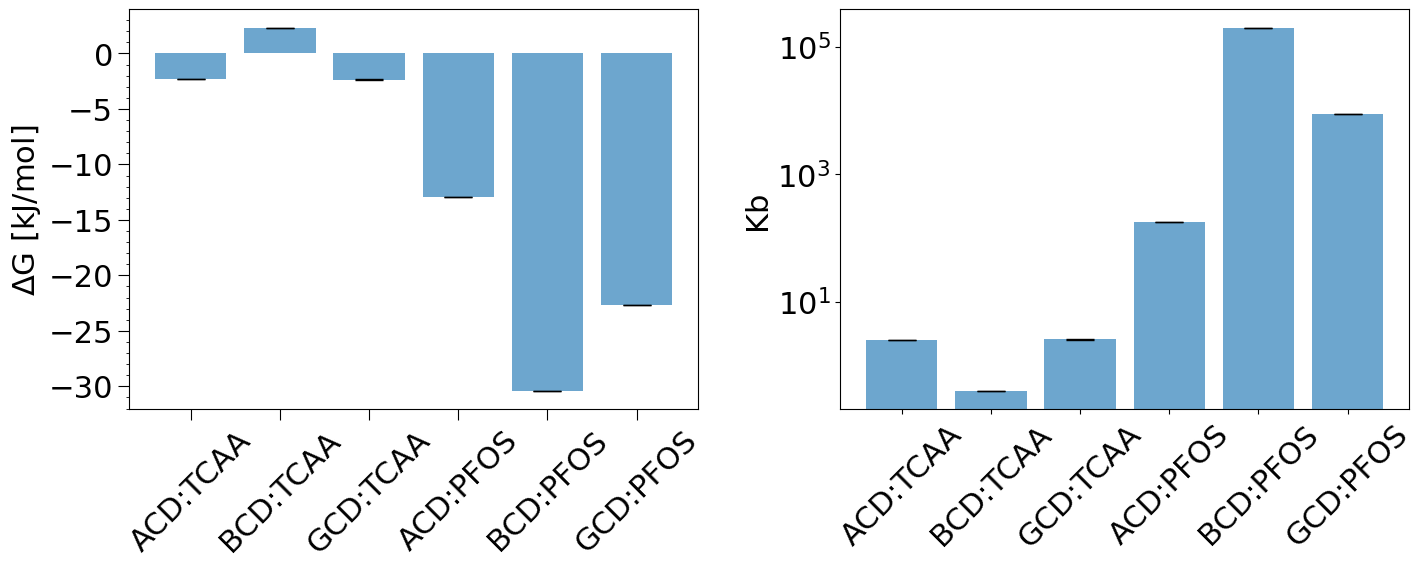

In [14]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

# Set the figure size
fig = plt.figure(figsize=(16, 5))

# Adjust spacing
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.25, hspace=0.25)

# Create a 3x3 grid
grid = GridSpec(1, 2)

probe= ['acd','bcd','gcd']
analyte = ['TCAA','pfos']

blocks = 3

deltag_kb_probe_analyte = {}

for k, kk in enumerate(analyte):
    for i, ii in enumerate(probe):
        
        selected_data = deltag_kb_probe_analyte_block
        
        deltag_blocks = []
        kb_blocks = []
        for bb in range(blocks):
            deltag = selected_data[ii+'_'+kk]['block'+str(bb)]['deltag']
            kb = selected_data[ii+'_'+kk]['block'+str(bb)]['kb']
            deltag_blocks.append(deltag)
            kb_blocks.append(kb)
            
            #print(deltag, kb)
            
        deltag_blocks = np.array(deltag_blocks)
        kb_blocks = np.array(kb_blocks)
        
        
        deltag_kb_probe_analyte[ii+'_'+kk] = {'avg_deltag': np.mean(deltag_blocks),
                                              'sd_deltag': np.std(deltag_blocks),
                                              'avg_kb': np.mean(kb_blocks),
                                              'sd_kb': np.std(kb_blocks)}

        
        
   

def convert_dict_of_dict(input_dict):
    result_dict = {}

    # Iterate through outer keys
    for outer_key, inner_dict in input_dict.items():
        # Iterate through inner keys
        for inner_key, value in inner_dict.items():
            # Check if the inner key is already in the result dictionary
            if inner_key not in result_dict:
                result_dict[inner_key] = {}

            # Add the value corresponding to the outer key
            result_dict[inner_key][outer_key] = value

    return result_dict

deltag_kb_probe_analyte = convert_dict_of_dict(deltag_kb_probe_analyte)



# # Create subplots
ax = plt.subplot(grid[0, 0])
# Extract keys and values from the dictionary
categories = list(deltag_kb_probe_analyte['avg_deltag'].keys())
values = list(deltag_kb_probe_analyte['avg_deltag'].values())
errors = list(deltag_kb_probe_analyte['sd_deltag'].values())

print(errors)

# Plotting a bar chart
ax.bar(categories, values, yerr=errors, align='center', alpha=0.65, ecolor='black', capsize=10)
print(categories)
ax.set_xticks(categories, ['ACD:TCAA', 'BCD:TCAA', 'GCD:TCAA', 'ACD:PFOS', 'BCD:PFOS', 'GCD:PFOS'], rotation=45)
    
ax.set_ylabel(r'$\Delta$G [kJ/mol]')

#ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(5))
#ax.xaxis.set_minor_locator(AutoMinorLocator(n=5))
ax.yaxis.set_minor_locator(AutoMinorLocator(n=5))
ax.tick_params(which='major', length=8)
ax.tick_params(which='minor', length=2)


# # Create subplots
ax = plt.subplot(grid[0, 1])
# Extract keys and values from the dictionary
categories = list(deltag_kb_probe_analyte['avg_kb'].keys())
values = list(deltag_kb_probe_analyte['avg_kb'].values())
errors = list(deltag_kb_probe_analyte['sd_kb'].values())

print(errors)

# Plotting a bar chart
ax.bar(categories, values, yerr=errors, align='center', alpha=0.65, ecolor='black', capsize=10)
print(categories)
ax.set_xticks(categories, ['ACD:TCAA', 'BCD:TCAA', 'GCD:TCAA', 'ACD:PFOS', 'BCD:PFOS', 'GCD:PFOS'], rotation=45)
    
ax.set_ylabel(r'Kb')
ax.set_yscale('log')

#ax.xaxis.set_major_locator(MultipleLocator(0.5))
# ax.yaxis.set_major_locator(MultipleLocator(1000))
# #ax.xaxis.set_minor_locator(AutoMinorLocator(n=5))
# ax.yaxis.set_minor_locator(AutoMinorLocator(n=5))
# ax.tick_params(which='major', length=8)
# ax.tick_params(which='minor', length=2)
        

